In [2]:
import numpy as np
import cv2
import os, sys, glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from sklearn.cross_validation import train_test_split
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
### from sklearn.model_selection import train_test_split

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from PIL import Image

import processing as ps

### Sample Images (64x64)

In [11]:
path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/'
imgfiles = glob.glob(os.path.join(path,'*.png'))

savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/'
count = 10000
for file in imgfiles:
    filename, ext = os.path.splitext( os.path.basename(file) )
    img = cv2.imread(file)

    cv2.imwrite(os.path.join(savepath,'cartest'+'{}'.format(count).zfill(5)+'.png'), img)
    count += 1

In [24]:
path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/'
imgfiles = glob.glob(os.path.join(path,'not*.png'))

savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/'
count = 10000
for file in imgfiles:
    filename, ext = os.path.splitext( os.path.basename(file) )
    img = cv2.imread(file)

    cv2.imwrite(os.path.join(savepath,'notcartest'+'{}'.format(count).zfill(5)+'.png'), img)
    count += 1

In [203]:
paths = ['C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/']
imgfiles = glob.glob(os.path.join(path,'*.png'))

savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/64x/'

for file in imgfiles:
    filename, ext = os.path.splitext( os.path.basename(file) )
    img = cv2.imread(file)

    # Select a small fraction of pixels to plot by subsampling it
    scale = min(img.shape[0], img.shape[1]) / 64  # at least 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)),\
                           interpolation=cv2.INTER_NEAREST)

    if img_small.shape[0] > 64:
        steps = img_small.shape[0]//64
        for step in range(steps):
            cv2.imwrite(os.path.join(savepath,filename+'-s-{}.png'.format(step)), img_small[64*step:64*(step+1), 0:64])
        if img_small.shape[0]%64 > 0:
            cv2.imwrite(os.path.join(savepath,filename+'-s-{}.png'.format(steps)), img_small[-64:, 0:64])
    
    else:
        steps = img_small.shape[1]//64
        for step in range(steps):
            cv2.imwrite(os.path.join(savepath,filename+'-s-{}.png'.format(step)), img_small[0:64, 64*step:64*(step+1)])
        if img_small.shape[1]%64 > 0:
            cv2.imwrite(os.path.join(savepath,filename+'-s-{}.png'.format(steps)), img_small[0:64, -64:])

In [204]:
paths = ['C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/']
imgfiles = glob.glob(os.path.join(path,'*.png'))

savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/64x/'

for file in imgfiles:
    filename, ext = os.path.splitext( os.path.basename(file) )
    img_small = cv2.imread(file)


    if img_small.shape[0] > 64:
        steps = img_small.shape[0]//64
        for step in range(steps):
            cv2.imwrite(os.path.join(savepath,filename+'-d-{}.png'.format(step)), img_small[64*step:64*(step+1), 0:64])
        if img_small.shape[0]%64 > 0:
            cv2.imwrite(os.path.join(savepath,filename+'-d-{}.png'.format(steps)), img_small[-64:, 0:64])
    
    if img_small.shape[1] > 64:
        steps = img_small.shape[1]//64
        for step in range(steps):
            cv2.imwrite(os.path.join(savepath,filename+'-d-{}.png'.format(step)), img_small[0:64, 64*step:64*(step+1)])
        if img_small.shape[1]%64 > 0:
            cv2.imwrite(os.path.join(savepath,filename+'-d-{}.png'.format(steps)), img_small[0:64, -64:])

In [26]:
paths = ['C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles/vehicles/GTI_Far/',
        'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles/vehicles/GTI_Left/',
        'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles/vehicles/GTI_MiddleClose/',
        'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles/vehicles/GTI_Right/',
        'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles/vehicles/KITTI_extracted/'
       ]
count = 0

for path in paths:
    imgfiles = glob.glob(os.path.join(path,'*.png'))

    savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles_nonvehicles/'

    for file in imgfiles:
        filename, ext = os.path.splitext( os.path.basename(file) )
        img = cv2.imread(file)

        # Select a small fraction of pixels to plot by subsampling it
        scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
        img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)),\
                               interpolation=cv2.INTER_NEAREST)

        cv2.imwrite(os.path.join(savepath,'car'+'{}'.format(count).zfill(5)+'.png'), img_small)
        
        count +=1

In [27]:
paths = ['C:/Users/tyone/Udacity/CarND-Vehicle-Detection/non-vehicles/non-vehicles/Extras',
         'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/non-vehicles/non-vehicles/GTI'
        ]
count = 0

    
for path in paths:
    imgfiles = glob.glob(os.path.join(path,'*.png'))

    savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles_nonvehicles/'

    for file in imgfiles:
        filename, ext = os.path.splitext( os.path.basename(file) )
        img = cv2.imread(file)

        # Select a small fraction of pixels to plot by subsampling it
        scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
        img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)),\
                               interpolation=cv2.INTER_NEAREST)

        cv2.imwrite(os.path.join(savepath,'notcar'+'{}'.format(count).zfill(5)+'.png'), img_small)
        
        count +=1

# Classifier

### Dataset

In [3]:
# Divide up into cars and notcars
path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles_nonvehicles/'
imgfiles = glob.glob(os.path.join(path,'*.png'))

cars = []
notcars = []

# file, filename
for file in imgfiles:
    filename, ext = os.path.splitext( os.path.basename(file) )
    if ('notcar' in filename):
        notcars.append(file)
    else:
        cars.append(file)

In [4]:
print('cars:',len(cars),', notcars:',len(notcars))


cars: 10069 , notcars: 11617


### Color Classifier

- Extract Features

In [5]:
spatial = 32
histbin = 32

### RGB&HLS

In [356]:
# cars, notcars = list of filenames

car_features_clr_rgb = ps.extract_features_clr(cars, cspace='YCrCb', spatial_size=(spatial, spatial),\
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features_clr_rgb = ps.extract_features_clr(notcars, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

car_features_clr_hls = ps.extract_features_clr(cars, cspace='HLS', spatial_size=(spatial, spatial),\
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features_clr_hls = ps.extract_features_clr(notcars, cspace='HLS', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500


- Save & Load feature_data

In [357]:
#"""
# Save feature data
np.save('./feature_data/small_size/car_features_clr_YCrCb.npy',car_features_clr_rgb)
np.save('./feature_data/small_size/notcar_features_clr_YCrCb.npy',notcar_features_clr_rgb)
np.save('./feature_data/small_size/car_features_clr_hls.npy',car_features_clr_hls)
np.save('./feature_data/small_size/notcar_features_clr_hls.npy',notcar_features_clr_hls)
#"""


In [6]:
#"""
# Load feature data
car_features_clr_rgb    = np.load('./feature_data/small_size/car_features_clr_YCrCb.npy')
notcar_features_clr_rgb = np.load('./feature_data/small_size/notcar_features_clr_YCrCb.npy')
car_features_clr_hls    = np.load('./feature_data/small_size/car_features_clr_hls.npy')
notcar_features_clr_hls = np.load('./feature_data/small_size/notcar_features_clr_hls.npy')
#"""

In [7]:
print(np.array(car_features_clr_rgb).shape)
print(np.array(notcar_features_clr_rgb).shape)
print(np.array(car_features_clr_hls).shape)
print(np.array(notcar_features_clr_hls).shape)

(10069, 3168)
(11617, 3168)
(10069, 3168)
(11617, 3168)


- Concatenate (car & notcar features)
- Standardize
- Separate Training & Test dataset

In [8]:
car_features_clr = np.hstack((car_features_clr_rgb, car_features_clr_hls))
notcar_features_clr = np.hstack((notcar_features_clr_rgb, notcar_features_clr_hls))

print(car_features_clr.shape)
print(notcar_features_clr.shape)

(10069, 6336)
(11617, 6336)


### HOG Classifier

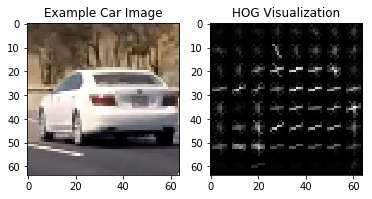

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob
from skimage.feature import hog
#from skimage.feature import hog
#from skimage import color, exposure
%matplotlib inline

# Read in our vehicles and non-vehicles
path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/vehicles_nonvehicles/'
imgfiles = glob.glob(os.path.join(path,'*.png'))

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


imgfile = imgfiles[10000]
image = mpimg.imread(imgfile)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')



- Extract Features

In [9]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [361]:
t=time.time()

car_features_hog = ps.extract_features_hog(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features_hog = ps.extract_features_hog(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


C:\Users\tyone\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


319.6 Seconds to extract HOG features...


- Save & Load Feature data

In [362]:
#"""
# Save feature data
np.save('./feature_data/small_size/car_features_hog_YCrCb_ALL.npy',car_features_hog)
np.save('./feature_data/small_size/notcar_features_hog_YCrCb_ALL.npy',notcar_features_hog)
#"""


In [10]:
#"""
# Load feature data
car_features_hog    = np.load('./feature_data/small_size/car_features_hog_YCrCb_ALL.npy')
notcar_features_hog = np.load('./feature_data/small_size/notcar_features_hog_YCrCb_ALL.npy')
#"""

In [11]:
print(np.array(car_features_hog).shape)
print(np.array(notcar_features_hog).shape)

(10069, 5292)
(11617, 5292)


### Combined Classifier (Color & HOG)

In [12]:
car_features_comb = np.hstack((car_features_clr, car_features_hog))
notcar_features_comb = np.hstack((notcar_features_clr, notcar_features_hog))

print(car_features_comb.shape)
print(notcar_features_comb.shape)

(10069, 11628)
(11617, 11628)


- Concatenate (car & notcar features)
- Standardize
- Separate Training & Test dataset

In [13]:
# Create an array stack of feature vectors
X_comb = np.vstack((car_features_comb, notcar_features_comb)).astype(np.float64)                        
# Fit a per-column scaler
X_comb_scaler = StandardScaler().fit(X_comb)
# Apply the scaler to X
scaled_X_comb = X_comb_scaler.transform(X_comb)

# Define the labels vector
y_comb = np.hstack((np.ones(len(car_features_comb)), np.zeros(len(notcar_features_comb))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_comb_train, X_comb_test, y_comb_train, y_comb_test = \
            train_test_split(scaled_X_comb, y_comb, test_size=0.2, random_state=rand_state)
    
print('Using spatial binning of:',spatial,'and', histbin,'histogram bins')
print('Feature vector length:', len(X_comb_train[0]))


Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 11628


- PCA case

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)  #20
pca.fit(scaled_X_comb)
scaled_X_comb_pca = pca.transform(scaled_X_comb)

sum(pca.explained_variance_ratio_)  #累積寄与率(復元率)

0.39434593432424087

In [15]:
print(scaled_X_comb_pca.shape)

(21686, 20)


### Split Data: Train & Test 

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_comb_pca_train, X_comb_pca_test, y_comb_train, y_comb_test = \
            train_test_split(scaled_X_comb_pca, y_comb, test_size=0.1, random_state=rand_state)
    
print('Using spatial binning of:',spatial,'and', histbin,'histogram bins')
print('Feature vector length:', len(X_comb_pca_train[0]))


Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 20


### Classifier: 

### Random Forest

In [17]:
rf_comb_pca = RandomForestClassifier(n_estimators=20) #20

t=time.time()
rf_comb_pca.fit(X_comb_pca_train, y_comb_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train RF_pca...')


# Check the score of the RF
print('Test Accuracy of RF_pca = ', round(rf_comb_pca.score(X_comb_pca_test, y_comb_test), 4))


0.86 Seconds to train RF_pca...
Test Accuracy of RF_pca =  0.9857


- PCA:   10 (0.476) ,  n_estimators:   10 , => 0.965
- PCA:   10 (0.476) ,  n_estimators:   20 , => 0.972
- PCA:   20 (0.551) ,  n_estimators:   10 , => 0.977
- PCA:   20 (0.551) ,  n_estimators:   20 , => 0.986
- PCA:   20 (0.551) ,  n_estimators:   50 , => 0.984
- PCA:   50 (0.644) ,  n_estimators:   50 , => 0.988
- PCA:   50 (0.644) ,  n_estimators:  500 , => 0.9899
- PCA:   50 (0.644) ,  n_estimators: 1000 , => 0.9904
- PCA:  100 (0.713) ,  n_estimators:   10 , => 0.9702
- PCA:  100 (0.713) ,  n_estimators:   50 , => 0.986
- PCA:  100 (0.713) ,  n_estimators:  500 , => 0.9916 #
- PCA:  200 (0.713) ,  n_estimators:  500 , => 0.9862
- PCA:  500 (0.872) ,  n_estimators:   50 , => 0.981
- PCA:  500 (0.872) ,  n_estimators:  500 , => 0.9862
- PCA: 1000 (0.934) ,  n_estimators:   50 , => 0.96
- PCA: 2000 (0.97 ) ,  n_estimators:   50 , => 0.92
- PCA: 4000 (0.997) ,  n_estimators:   50 , => 0.86


-Ref

In [29]:
parameters = {'n_estimators': [50],
              'min_samples_split': [10, 30, 50, 100],
              'max_depth': [10, 30, 50, 100]             
             }

#'n_estimators': [5,10,30,50],

rf_comb_pca = GridSearchCV(RandomForestClassifier(), parameters)
rf_comb_pca.fit(X_comb_pca_train, y_comb_train)

print(rf_comb_pca.best_estimator_)

KeyboardInterrupt: 

In [69]:
print('Test Accuracy of RF_pca = ', round(rf_comb_pca.score(X_comb_pca_test, y_comb_test), 4))

Test Accuracy of RF_pca =  0.9868


### Linear SVC

In [19]:
svc_comb = LinearSVC()

t=time.time()
svc_comb.fit(X_comb_pca_train, y_comb_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


# Check the score of the SVC
print('Test Accuracy of RF = ', round(svc_comb.score(X_comb_pca_test, y_comb_test), 4))


1.5 Seconds to train SVC...
Test Accuracy of RF =  0.8872


- PCA:   50 (0.644)  => 0.9459
- PCA:  100 (0.7) ,  => 0.9611
- PCA:  500 (0.872)  => 0.9665
- PCA: 1000 (0.934)  => 0.9755
- PCA: 2000 (0.97 )  => 0.9778
- PCA: 4000 (0.997)  => 0.9789

### Detect & Track

255


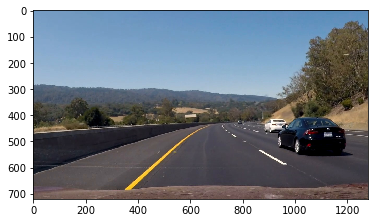

(720, 1280, 3)

In [42]:
# example image
"""
path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images'
image = mpimg.imread(os.path.join(path,'test2.jpg'))
"""
"""
path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/image_frames/'
imgfiles = glob.glob(os.path.join(path,'*.jpg'))
image = mpimg.imread(imgfiles[1])
"""

path = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/image_frames/'
filename = 'image_frame00770.jpg'
imgfiles = os.path.join(path,filename)
image = mpimg.imread(imgfiles)

print(image[:,:,0].max())

plt.imshow(image)
plt.show()
image.shape

- Detect (box_list)

In [43]:
ystart = 350
ystop = 680
scales = [0.9, 1.5] #1.3, 2, 3
#scales = [0.7, 0.9, 1.3] #1.3, 2, 3
    
# find_cars function
box_list = []
t = time.time()
for scale in scales:
#    bbox_list = ps.find_cars_Hue_pca(image, ystart, ystop, scale, svc_comb, X_comb_scaler, pca, \
#                                   orient, pix_per_cell, cell_per_block, spatial, histbin, window_size=64)
    bbox_list = ps.find_cars_pca(image, ystart, ystop, scale, rf_comb_pca, X_comb_scaler, pca, \
                                   orient, pix_per_cell, cell_per_block, spatial, histbin, window_size=64)
#
#    bbox_list = ps.find_cars_Hue_pca(image, ystart, ystop, scale, rf_comb_pca, X_comb_scaler, pca, \
#                                   orient, pix_per_cell, cell_per_block, spatial, histbin, window_size=64)
    
    
    box_list.append(bbox_list)
t2 = time.time()
print(round(t2-t, 6), 'Seconds to detect')

5.851832 Seconds to detect


In [44]:
print(box_list)

[[[(259, 393), (316, 450)], [(878, 407), (935, 464)], [(878, 422), (935, 479)], [(892, 407), (949, 464)], [(892, 422), (949, 479)], [(907, 407), (964, 464)], [(921, 407), (978, 464)], [(921, 422), (978, 479)], [(936, 422), (993, 479)], [(936, 436), (993, 493)], [(936, 479), (993, 536)], [(950, 422), (1007, 479)], [(950, 436), (1007, 493)], [(950, 465), (1007, 522)], [(950, 479), (1007, 536)], [(950, 494), (1007, 551)], [(964, 407), (1021, 464)], [(964, 422), (1021, 479)], [(964, 436), (1021, 493)], [(964, 479), (1021, 536)], [(964, 494), (1021, 551)], [(979, 407), (1036, 464)], [(979, 422), (1036, 479)], [(979, 479), (1036, 536)], [(993, 393), (1050, 450)], [(993, 407), (1050, 464)], [(993, 436), (1050, 493)], [(993, 465), (1050, 522)], [(993, 479), (1050, 536)], [(993, 494), (1050, 551)], [(1008, 393), (1065, 450)], [(1008, 479), (1065, 536)], [(1065, 407), (1122, 464)], [(1080, 378), (1137, 435)], [(1080, 393), (1137, 450)], [(1094, 393), (1151, 450)], [(1094, 407), (1151, 464)], [(1

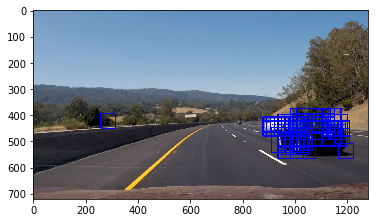

In [45]:
b_list = []
image_copy = np.copy(image)

for boxs in box_list:
    for box in boxs:
        cv2.rectangle(image_copy,(box[0][0],box[0][1]),(box[1][0],box[1][1]),(0,0,255),3) 
        b_list.append(box)
        
plt.imshow(image_copy)
plt.show()

- Tracking

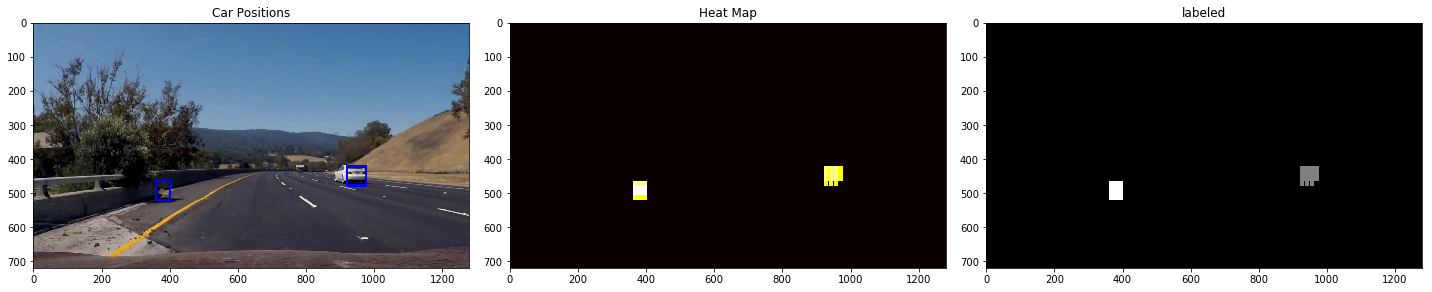

In [38]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = ps.add_heat(heat,b_list)

# Apply threshold to help remove false positives
heat = ps.apply_threshold(heat,5)
#heat = ps.apply_threshold(heat,30)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = ps.draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(labels[0], cmap='gray')
plt.title('labeled')
fig.tight_layout()
plt.show()

### Image cut

In [ ]:
image_c = np.copy(image)

imgbox = []
count = 0
for boxs in box_list:
    for box in boxs:
        image_c = image[box[0][1]:box[1][1],box[0][0]:box[1][0]] 
        imgbox.append(image_c)
        print(count)
        plt.figure(figsize=(2,2))
        plt.imshow(image_c)
        print(image_c.shape)
        plt.show()
        count+=1

0
(57, 57, 3)


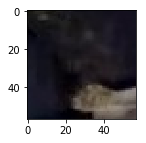

1
(57, 57, 3)


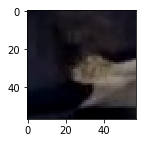

2
(57, 57, 3)


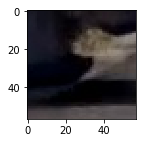

3
(57, 57, 3)


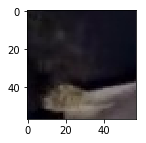

4
(57, 57, 3)


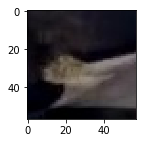

5
(57, 57, 3)


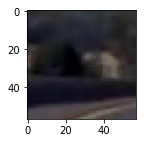

6
(57, 57, 3)


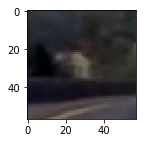

7
(57, 57, 3)


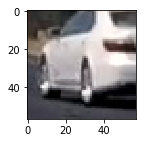

8
(57, 57, 3)


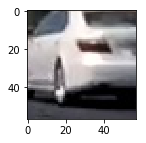

9
(57, 57, 3)


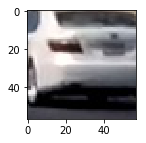

10
(57, 57, 3)


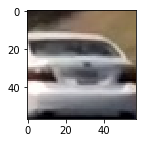

11
(57, 57, 3)


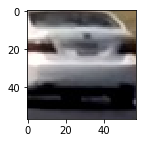

12
(57, 57, 3)


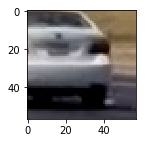

13
(57, 57, 3)


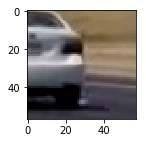

14
(96, 96, 3)


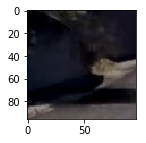

15
(96, 96, 3)


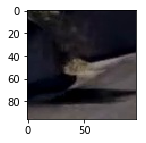

16
(96, 96, 3)


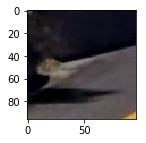

17
(96, 96, 3)


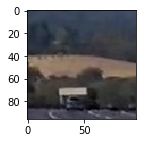

18
(96, 96, 3)


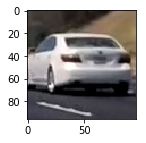

19
(96, 96, 3)


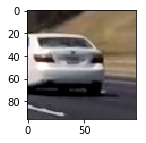

In [39]:
image_c = np.copy(image)

imgbox = []
count = 0
for boxs in box_list:
    for box in boxs:
        image_c = image[box[0][1]:box[1][1],box[0][0]:box[1][0]] 
        imgbox.append(image_c)
        print(count)
        plt.figure(figsize=(2,2))
        plt.imshow(image_c)
        print(image_c.shape)
        plt.show()
        count+=1

In [341]:
ncar = [0,]
savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/image_frames/car/'

for i in ncar:
    img_ = imgbox[i]
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(savepath,'notcar_'+filename+'_{}.png'.format(i)), img_)

    

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
class Prevs:
    def __init__(self):
        self.frames = []

In [20]:
fr = Prevs()

def process_image(image):

#    image = cv2.resize(image,(1280//2,720//2))

#    ystart = 350//2
#    ystop = 680//2
    ystart = 350
    ystop = 680
    scales = [0.9, 1.5,]

    # find_cars function
    box_list = []

    for scale in scales:
        bbox_list = ps.find_cars_pca(image, ystart, ystop, scale, rf_comb_pca, X_comb_scaler, pca, \
                                       orient, pix_per_cell, cell_per_block, spatial, histbin, window_size=64)
#        bbox_list = ps.find_cars_Hue_pca(image, ystart, ystop, scale, rf_comb_pca, X_comb_scaler, pca, \
#                                       orient, pix_per_cell, cell_per_block, spatial, histbin, window_size=64)
        box_list.append(bbox_list)

    b_list = []
    for boxs in box_list:
        for box in boxs:
            b_list.append(box)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = ps.add_heat(heat,b_list)

    # Apply threshold to help remove false positives
    heat = ps.apply_threshold(heat,5)
    #heat = ps.apply_threshold(heat,30)

    print(heat.max())
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    print(heatmap.max())
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print(labels[1])
    draw_img = ps.draw_labeled_bboxes(np.copy(image), labels)

    return draw_img


In [21]:
#project_video_output = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/test_video_001.mp4'  # output file
project_video_output = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_YCbCr.mp4'  # output file
clip1 = VideoFileClip("C:/Users/tyone/Udacity/CarND-Vehicle-Detection/project_video.mp4")  # input file
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

0.0
0.0
0
[MoviePy] >>>> Building video C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_YCbCr.mp4
[MoviePy] Writing video C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_YCbCr.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

0.0
0.0
0


  0%|                                                                               | 1/1261 [00:05<1:45:45,  5.04s/it]

0.0
0.0
0


  0%|▏                                                                              | 2/1261 [00:10<1:47:31,  5.12s/it]

0.0
0.0
0


  0%|▏                                                                              | 3/1261 [00:15<1:46:46,  5.09s/it]

0.0
0.0
0


  0%|▎                                                                              | 4/1261 [00:20<1:47:39,  5.14s/it]

0.0
0.0
0


  0%|▎                                                                              | 5/1261 [00:25<1:47:50,  5.15s/it]

0.0
0.0
0


  0%|▍                                                                              | 6/1261 [00:30<1:47:13,  5.13s/it]

0.0
0.0
0


  1%|▍                                                                              | 7/1261 [00:35<1:46:48,  5.11s/it]

0.0
0.0
0


  1%|▌                                                                              | 8/1261 [00:41<1:46:35,  5.10s/it]

0.0
0.0
0


  1%|▌                                                                              | 9/1261 [00:46<1:46:25,  5.10s/it]

0.0
0.0
0


  1%|▌                                                                             | 10/1261 [00:51<1:49:04,  5.23s/it]

0.0
0.0
0


  1%|▋                                                                             | 11/1261 [00:56<1:47:23,  5.16s/it]

0.0
0.0
0


  1%|▋                                                                             | 12/1261 [01:01<1:46:46,  5.13s/it]

0.0
0.0
0


  1%|▊                                                                             | 13/1261 [01:06<1:46:12,  5.11s/it]

0.0
0.0
0


  1%|▊                                                                             | 14/1261 [01:11<1:45:48,  5.09s/it]

0.0
0.0
0


  1%|▉                                                                             | 15/1261 [01:16<1:45:24,  5.08s/it]

0.0
0.0
0


  1%|▉                                                                             | 16/1261 [01:21<1:45:09,  5.07s/it]

0.0
0.0
0


  1%|█                                                                             | 17/1261 [01:27<1:45:44,  5.10s/it]

0.0
0.0
0


  1%|█                                                                             | 18/1261 [01:32<1:45:39,  5.10s/it]

0.0
0.0
0


  2%|█▏                                                                            | 19/1261 [01:37<1:45:56,  5.12s/it]

0.0
0.0
0


  2%|█▏                                                                            | 20/1261 [01:42<1:46:06,  5.13s/it]

0.0
0.0
0


  2%|█▎                                                                            | 21/1261 [01:47<1:45:54,  5.12s/it]

0.0
0.0
0


  2%|█▎                                                                            | 22/1261 [01:52<1:43:43,  5.02s/it]

0.0
0.0
0


  2%|█▍                                                                            | 23/1261 [01:57<1:42:25,  4.96s/it]

0.0
0.0
0


  2%|█▍                                                                            | 24/1261 [02:02<1:41:21,  4.92s/it]

0.0
0.0
0


  2%|█▌                                                                            | 25/1261 [02:06<1:40:36,  4.88s/it]

0.0
0.0
0


  2%|█▌                                                                            | 26/1261 [02:11<1:40:08,  4.86s/it]

0.0
0.0
0


  2%|█▋                                                                            | 27/1261 [02:16<1:39:51,  4.86s/it]

0.0
0.0
0


  2%|█▋                                                                            | 28/1261 [02:21<1:39:29,  4.84s/it]

0.0
0.0
0


  2%|█▊                                                                            | 29/1261 [02:26<1:39:16,  4.83s/it]

0.0
0.0
0


  2%|█▊                                                                            | 30/1261 [02:30<1:39:23,  4.84s/it]

0.0
0.0
0


  2%|█▉                                                                            | 31/1261 [02:35<1:39:27,  4.85s/it]

0.0
0.0
0


  3%|█▉                                                                            | 32/1261 [02:40<1:39:10,  4.84s/it]

0.0
0.0
0


  3%|██                                                                            | 33/1261 [02:45<1:39:06,  4.84s/it]

0.0
0.0
0


  3%|██                                                                            | 34/1261 [02:50<1:41:15,  4.95s/it]

0.0
0.0
0


  3%|██▏                                                                           | 35/1261 [02:55<1:40:30,  4.92s/it]

0.0
0.0
0


  3%|██▏                                                                           | 36/1261 [03:00<1:39:38,  4.88s/it]

0.0
0.0
0


  3%|██▎                                                                           | 37/1261 [03:05<1:39:13,  4.86s/it]

0.0
0.0
0


  3%|██▎                                                                           | 38/1261 [03:10<1:39:05,  4.86s/it]

0.0
0.0
0


  3%|██▍                                                                           | 39/1261 [03:14<1:38:46,  4.85s/it]

0.0
0.0
0


  3%|██▍                                                                           | 40/1261 [03:19<1:38:35,  4.84s/it]

0.0
0.0
0


  3%|██▌                                                                           | 41/1261 [03:24<1:38:17,  4.83s/it]

0.0
0.0
0


  3%|██▌                                                                           | 42/1261 [03:29<1:38:19,  4.84s/it]

0.0
0.0
0


  3%|██▋                                                                           | 43/1261 [03:34<1:38:17,  4.84s/it]

0.0
0.0
0


  3%|██▋                                                                           | 44/1261 [03:39<1:38:07,  4.84s/it]

0.0
0.0
0


  4%|██▊                                                                           | 45/1261 [03:43<1:37:53,  4.83s/it]

0.0
0.0
0


  4%|██▊                                                                           | 46/1261 [03:48<1:37:48,  4.83s/it]

0.0
0.0
0


  4%|██▉                                                                           | 47/1261 [03:53<1:37:32,  4.82s/it]

0.0
0.0
0


  4%|██▉                                                                           | 48/1261 [03:58<1:37:33,  4.83s/it]

0.0
0.0
0


  4%|███                                                                           | 49/1261 [04:03<1:37:29,  4.83s/it]

0.0
0.0
0


  4%|███                                                                           | 50/1261 [04:07<1:37:29,  4.83s/it]

0.0
0.0
0


  4%|███▏                                                                          | 51/1261 [04:12<1:37:24,  4.83s/it]

0.0
0.0
0


  4%|███▏                                                                          | 52/1261 [04:17<1:37:09,  4.82s/it]

0.0
0.0
0


  4%|███▎                                                                          | 53/1261 [04:22<1:37:10,  4.83s/it]

0.0
0.0
0


  4%|███▎                                                                          | 54/1261 [04:27<1:37:26,  4.84s/it]

0.0
0.0
0


  4%|███▍                                                                          | 55/1261 [04:32<1:37:19,  4.84s/it]

0.0
0.0
0


  4%|███▍                                                                          | 56/1261 [04:36<1:37:05,  4.83s/it]

0.0
0.0
0


  5%|███▌                                                                          | 57/1261 [04:41<1:37:02,  4.84s/it]

0.0
0.0
0


  5%|███▌                                                                          | 58/1261 [04:46<1:36:59,  4.84s/it]

0.0
0.0
0


  5%|███▋                                                                          | 59/1261 [04:51<1:39:38,  4.97s/it]

0.0
0.0
0


  5%|███▋                                                                          | 60/1261 [04:56<1:38:43,  4.93s/it]

0.0
0.0
0


  5%|███▊                                                                          | 61/1261 [05:01<1:37:54,  4.90s/it]

0.0
0.0
0


  5%|███▊                                                                          | 62/1261 [05:06<1:37:12,  4.86s/it]

0.0
0.0
0


  5%|███▉                                                                          | 63/1261 [05:11<1:36:51,  4.85s/it]

0.0
0.0
0


  5%|███▉                                                                          | 64/1261 [05:16<1:36:33,  4.84s/it]

0.0
0.0
0


  5%|████                                                                          | 65/1261 [05:20<1:36:12,  4.83s/it]

0.0
0.0
0


  5%|████                                                                          | 66/1261 [05:25<1:36:15,  4.83s/it]

0.0
0.0
0


  5%|████▏                                                                         | 67/1261 [05:30<1:36:12,  4.83s/it]

0.0
0.0
0


  5%|████▏                                                                         | 68/1261 [05:35<1:35:58,  4.83s/it]

0.0
0.0
0


  5%|████▎                                                                         | 69/1261 [05:40<1:36:07,  4.84s/it]

0.0
0.0
0


  6%|████▎                                                                         | 70/1261 [05:45<1:36:02,  4.84s/it]

0.0
0.0
0


  6%|████▍                                                                         | 71/1261 [05:49<1:35:57,  4.84s/it]

0.0
0.0
0


  6%|████▍                                                                         | 72/1261 [05:54<1:35:58,  4.84s/it]

0.0
0.0
0


  6%|████▌                                                                         | 73/1261 [05:59<1:35:43,  4.83s/it]

0.0
0.0
0


  6%|████▌                                                                         | 74/1261 [06:04<1:35:36,  4.83s/it]

0.0
0.0
0


  6%|████▋                                                                         | 75/1261 [06:09<1:35:30,  4.83s/it]

0.0
0.0
0


  6%|████▋                                                                         | 76/1261 [06:13<1:35:13,  4.82s/it]

0.0
0.0
0


  6%|████▊                                                                         | 77/1261 [06:18<1:35:05,  4.82s/it]

0.0
0.0
0


  6%|████▊                                                                         | 78/1261 [06:23<1:34:56,  4.82s/it]

0.0
0.0
0


  6%|████▉                                                                         | 79/1261 [06:28<1:35:05,  4.83s/it]

0.0
0.0
0


  6%|████▉                                                                         | 80/1261 [06:33<1:35:12,  4.84s/it]

0.0
0.0
0


  6%|█████                                                                         | 81/1261 [06:38<1:35:17,  4.85s/it]

0.0
0.0
0


  7%|█████                                                                         | 82/1261 [06:43<1:35:00,  4.84s/it]

0.0
0.0
0


  7%|█████▏                                                                        | 83/1261 [06:47<1:35:37,  4.87s/it]

0.0
0.0
0


  7%|█████▏                                                                        | 84/1261 [06:53<1:37:01,  4.95s/it]

0.0
0.0
0


  7%|█████▎                                                                        | 85/1261 [06:57<1:36:11,  4.91s/it]

0.0
0.0
0


  7%|█████▎                                                                        | 86/1261 [07:02<1:35:44,  4.89s/it]

0.0
0.0
0


  7%|█████▍                                                                        | 87/1261 [07:07<1:35:21,  4.87s/it]

0.0
0.0
0


  7%|█████▍                                                                        | 88/1261 [07:12<1:34:48,  4.85s/it]

0.0
0.0
0


  7%|█████▌                                                                        | 89/1261 [07:17<1:34:33,  4.84s/it]

0.0
0.0
0


  7%|█████▌                                                                        | 90/1261 [07:22<1:34:31,  4.84s/it]

0.0
0.0
0


  7%|█████▋                                                                        | 91/1261 [07:26<1:34:18,  4.84s/it]

0.0
0.0
0


  7%|█████▋                                                                        | 92/1261 [07:31<1:34:12,  4.83s/it]

0.0
0.0
0


  7%|█████▊                                                                        | 93/1261 [07:36<1:33:55,  4.82s/it]

0.0
0.0
0


  7%|█████▊                                                                        | 94/1261 [07:41<1:33:46,  4.82s/it]

0.0
0.0
0


  8%|█████▉                                                                        | 95/1261 [07:46<1:33:37,  4.82s/it]

0.0
0.0
0


  8%|█████▉                                                                        | 96/1261 [07:50<1:33:31,  4.82s/it]

0.0
0.0
0


  8%|██████                                                                        | 97/1261 [07:55<1:33:36,  4.83s/it]

0.0
0.0
0


  8%|██████                                                                        | 98/1261 [08:00<1:33:23,  4.82s/it]

0.0
0.0
0


  8%|██████                                                                        | 99/1261 [08:05<1:33:36,  4.83s/it]

0.0
0.0
0


  8%|██████                                                                       | 100/1261 [08:10<1:33:28,  4.83s/it]

0.0
0.0
0


  8%|██████▏                                                                      | 101/1261 [08:15<1:33:37,  4.84s/it]

0.0
0.0
0


  8%|██████▏                                                                      | 102/1261 [08:20<1:33:45,  4.85s/it]

0.0
0.0
0


  8%|██████▎                                                                      | 103/1261 [08:24<1:33:36,  4.85s/it]

0.0
0.0
0


  8%|██████▎                                                                      | 104/1261 [08:29<1:33:32,  4.85s/it]

0.0
0.0
0


  8%|██████▍                                                                      | 105/1261 [08:34<1:33:20,  4.84s/it]

0.0
0.0
0


  8%|██████▍                                                                      | 106/1261 [08:39<1:33:05,  4.84s/it]

0.0
0.0
0


  8%|██████▌                                                                      | 107/1261 [08:44<1:32:52,  4.83s/it]

0.0
0.0
0


  9%|██████▌                                                                      | 108/1261 [08:49<1:34:13,  4.90s/it]

0.0
0.0
0


  9%|██████▋                                                                      | 109/1261 [08:54<1:34:42,  4.93s/it]

0.0
0.0
0


  9%|██████▋                                                                      | 110/1261 [08:59<1:33:57,  4.90s/it]

0.0
0.0
0


  9%|██████▊                                                                      | 111/1261 [09:03<1:33:33,  4.88s/it]

0.0
0.0
0


  9%|██████▊                                                                      | 112/1261 [09:08<1:33:15,  4.87s/it]

0.0
0.0
0


  9%|██████▉                                                                      | 113/1261 [09:13<1:32:51,  4.85s/it]

0.0
0.0
0


  9%|██████▉                                                                      | 114/1261 [09:18<1:32:38,  4.85s/it]

0.0
0.0
0


  9%|███████                                                                      | 115/1261 [09:23<1:32:20,  4.83s/it]

0.0
0.0
0


  9%|███████                                                                      | 116/1261 [09:28<1:32:14,  4.83s/it]

0.0
0.0
0


  9%|███████▏                                                                     | 117/1261 [09:32<1:32:10,  4.83s/it]

0.0
0.0
0


  9%|███████▏                                                                     | 118/1261 [09:37<1:32:01,  4.83s/it]

0.0
0.0
0


  9%|███████▎                                                                     | 119/1261 [09:42<1:32:05,  4.84s/it]

0.0
0.0
0


 10%|███████▎                                                                     | 120/1261 [09:47<1:32:25,  4.86s/it]

0.0
0.0
0


 10%|███████▍                                                                     | 121/1261 [09:52<1:32:21,  4.86s/it]

0.0
0.0
0


 10%|███████▍                                                                     | 122/1261 [09:57<1:32:34,  4.88s/it]

0.0
0.0
0


 10%|███████▌                                                                     | 123/1261 [10:02<1:33:08,  4.91s/it]

0.0
0.0
0


 10%|███████▌                                                                     | 124/1261 [10:07<1:35:09,  5.02s/it]

0.0
0.0
0


 10%|███████▋                                                                     | 125/1261 [10:12<1:34:56,  5.01s/it]

0.0
0.0
0


 10%|███████▋                                                                     | 126/1261 [10:17<1:33:39,  4.95s/it]

0.0
0.0
0


 10%|███████▊                                                                     | 127/1261 [10:22<1:33:01,  4.92s/it]

0.0
0.0
0


 10%|███████▊                                                                     | 128/1261 [10:26<1:32:23,  4.89s/it]

0.0
0.0
0


 10%|███████▉                                                                     | 129/1261 [10:31<1:32:13,  4.89s/it]

0.0
0.0
0


 10%|███████▉                                                                     | 130/1261 [10:36<1:31:49,  4.87s/it]

0.0
0.0
0


 10%|███████▉                                                                     | 131/1261 [10:41<1:31:22,  4.85s/it]

0.0
0.0
0


 10%|████████                                                                     | 132/1261 [10:46<1:31:20,  4.85s/it]

0.0
0.0
0


 11%|████████                                                                     | 133/1261 [10:51<1:33:45,  4.99s/it]

0.0
0.0
0


 11%|████████▏                                                                    | 134/1261 [10:56<1:32:45,  4.94s/it]

0.0
0.0
0


 11%|████████▏                                                                    | 135/1261 [11:01<1:31:52,  4.90s/it]

0.0
0.0
0


 11%|████████▎                                                                    | 136/1261 [11:06<1:31:32,  4.88s/it]

0.0
0.0
0


 11%|████████▎                                                                    | 137/1261 [11:10<1:31:02,  4.86s/it]

0.0
0.0
0


 11%|████████▍                                                                    | 138/1261 [11:15<1:30:59,  4.86s/it]

0.0
0.0
0


 11%|████████▍                                                                    | 139/1261 [11:20<1:30:28,  4.84s/it]

0.0
0.0
0


 11%|████████▌                                                                    | 140/1261 [11:25<1:30:21,  4.84s/it]

8.0
8.0
1


 11%|████████▌                                                                    | 141/1261 [11:30<1:30:30,  4.85s/it]

6.0
6.0
2


 11%|████████▋                                                                    | 142/1261 [11:35<1:30:28,  4.85s/it]

6.0
6.0
1


 11%|████████▋                                                                    | 143/1261 [11:39<1:30:07,  4.84s/it]

0.0
0.0
0


 11%|████████▊                                                                    | 144/1261 [11:44<1:30:00,  4.83s/it]

7.0
7.0
1


 11%|████████▊                                                                    | 145/1261 [11:49<1:29:56,  4.84s/it]

6.0
6.0
1


 12%|████████▉                                                                    | 146/1261 [11:54<1:29:44,  4.83s/it]

8.0
8.0
1


 12%|████████▉                                                                    | 147/1261 [11:59<1:29:30,  4.82s/it]

7.0
7.0
2


 12%|█████████                                                                    | 148/1261 [12:04<1:29:33,  4.83s/it]

9.0
9.0
1


 12%|█████████                                                                    | 149/1261 [12:08<1:29:53,  4.85s/it]

11.0
11.0
1


 12%|█████████▏                                                                   | 150/1261 [12:13<1:29:35,  4.84s/it]

8.0
8.0
1


 12%|█████████▏                                                                   | 151/1261 [12:18<1:29:31,  4.84s/it]

9.0
9.0
1


 12%|█████████▎                                                                   | 152/1261 [12:23<1:29:14,  4.83s/it]

10.0
10.0
1


 12%|█████████▎                                                                   | 153/1261 [12:28<1:29:15,  4.83s/it]

13.0
13.0
1


 12%|█████████▍                                                                   | 154/1261 [12:33<1:29:10,  4.83s/it]

15.0
15.0
1


 12%|█████████▍                                                                   | 155/1261 [12:37<1:29:04,  4.83s/it]

14.0
14.0
1


 12%|█████████▌                                                                   | 156/1261 [12:42<1:28:55,  4.83s/it]

14.0
14.0
1


 12%|█████████▌                                                                   | 157/1261 [12:47<1:29:10,  4.85s/it]

14.0
14.0
1


 13%|█████████▋                                                                   | 158/1261 [12:52<1:31:00,  4.95s/it]

17.0
17.0
1


 13%|█████████▋                                                                   | 159/1261 [12:57<1:30:10,  4.91s/it]

17.0
17.0
1


 13%|█████████▊                                                                   | 160/1261 [13:02<1:29:24,  4.87s/it]

19.0
19.0
1


 13%|█████████▊                                                                   | 161/1261 [13:07<1:28:44,  4.84s/it]

15.0
15.0
1


 13%|█████████▉                                                                   | 162/1261 [13:12<1:28:28,  4.83s/it]

21.0
21.0
1


 13%|█████████▉                                                                   | 163/1261 [13:16<1:28:16,  4.82s/it]

23.0
23.0
1


 13%|██████████                                                                   | 164/1261 [13:21<1:27:58,  4.81s/it]

21.0
21.0
1


 13%|██████████                                                                   | 165/1261 [13:26<1:28:03,  4.82s/it]

21.0
21.0
1


 13%|██████████▏                                                                  | 166/1261 [13:31<1:27:52,  4.82s/it]

18.0
18.0
1


 13%|██████████▏                                                                  | 167/1261 [13:36<1:27:54,  4.82s/it]

21.0
21.0
1


 13%|██████████▎                                                                  | 168/1261 [13:40<1:27:41,  4.81s/it]

19.0
19.0
1


 13%|██████████▎                                                                  | 169/1261 [13:45<1:27:25,  4.80s/it]

21.0
21.0
1


 13%|██████████▍                                                                  | 170/1261 [13:50<1:27:14,  4.80s/it]

16.0
16.0
1


 14%|██████████▍                                                                  | 171/1261 [13:55<1:27:09,  4.80s/it]

18.0
18.0
1


 14%|██████████▌                                                                  | 172/1261 [14:00<1:27:04,  4.80s/it]

20.0
20.0
1


 14%|██████████▌                                                                  | 173/1261 [14:04<1:27:00,  4.80s/it]

19.0
19.0
1


 14%|██████████▌                                                                  | 174/1261 [14:09<1:26:51,  4.79s/it]

20.0
20.0
1


 14%|██████████▋                                                                  | 175/1261 [14:14<1:26:53,  4.80s/it]

22.0
22.0
1


 14%|██████████▋                                                                  | 176/1261 [14:19<1:26:48,  4.80s/it]

23.0
23.0
1


 14%|██████████▊                                                                  | 177/1261 [14:24<1:26:51,  4.81s/it]

19.0
19.0
1


 14%|██████████▊                                                                  | 178/1261 [14:28<1:26:49,  4.81s/it]

18.0
18.0
1


 14%|██████████▉                                                                  | 179/1261 [14:33<1:26:50,  4.82s/it]

21.0
21.0
1


 14%|██████████▉                                                                  | 180/1261 [14:38<1:26:45,  4.82s/it]

23.0
23.0
1


 14%|███████████                                                                  | 181/1261 [14:43<1:26:25,  4.80s/it]

24.0
24.0
1


 14%|███████████                                                                  | 182/1261 [14:48<1:26:42,  4.82s/it]

22.0
22.0
1


 15%|███████████▏                                                                 | 183/1261 [14:53<1:28:26,  4.92s/it]

23.0
23.0
1


 15%|███████████▏                                                                 | 184/1261 [14:58<1:27:47,  4.89s/it]

22.0
22.0
1


 15%|███████████▎                                                                 | 185/1261 [15:02<1:27:13,  4.86s/it]

25.0
25.0
1


 15%|███████████▎                                                                 | 186/1261 [15:07<1:27:05,  4.86s/it]

25.0
25.0
1


 15%|███████████▍                                                                 | 187/1261 [15:12<1:26:48,  4.85s/it]

26.0
26.0
1


 15%|███████████▍                                                                 | 188/1261 [15:17<1:26:31,  4.84s/it]

24.0
24.0
1


 15%|███████████▌                                                                 | 189/1261 [15:22<1:26:24,  4.84s/it]

24.0
24.0
1


 15%|███████████▌                                                                 | 190/1261 [15:27<1:26:13,  4.83s/it]

26.0
26.0
1


 15%|███████████▋                                                                 | 191/1261 [15:31<1:26:04,  4.83s/it]

27.0
27.0
1


 15%|███████████▋                                                                 | 192/1261 [15:36<1:25:48,  4.82s/it]

27.0
27.0
1


 15%|███████████▊                                                                 | 193/1261 [15:41<1:25:40,  4.81s/it]

22.0
22.0
1


 15%|███████████▊                                                                 | 194/1261 [15:46<1:25:31,  4.81s/it]

21.0
21.0
1


 15%|███████████▉                                                                 | 195/1261 [15:51<1:25:24,  4.81s/it]

25.0
25.0
1


 16%|███████████▉                                                                 | 196/1261 [15:55<1:25:22,  4.81s/it]

20.0
20.0
1


 16%|████████████                                                                 | 197/1261 [16:00<1:25:18,  4.81s/it]

21.0
21.0
1


 16%|████████████                                                                 | 198/1261 [16:05<1:25:15,  4.81s/it]

22.0
22.0
1


 16%|████████████▏                                                                | 199/1261 [16:10<1:25:11,  4.81s/it]

22.0
22.0
1


 16%|████████████▏                                                                | 200/1261 [16:15<1:25:06,  4.81s/it]

21.0
21.0
1


 16%|████████████▎                                                                | 201/1261 [16:20<1:25:02,  4.81s/it]

21.0
21.0
1


 16%|████████████▎                                                                | 202/1261 [16:24<1:24:59,  4.82s/it]

26.0
26.0
1


 16%|████████████▍                                                                | 203/1261 [16:29<1:24:42,  4.80s/it]

22.0
22.0
1


 16%|████████████▍                                                                | 204/1261 [16:34<1:24:42,  4.81s/it]

21.0
21.0
1


 16%|████████████▌                                                                | 205/1261 [16:39<1:24:37,  4.81s/it]

22.0
22.0
1


 16%|████████████▌                                                                | 206/1261 [16:44<1:24:33,  4.81s/it]

21.0
21.0
1


 16%|████████████▋                                                                | 207/1261 [16:49<1:25:25,  4.86s/it]

22.0
22.0
1


 16%|████████████▋                                                                | 208/1261 [16:54<1:26:26,  4.93s/it]

22.0
22.0
1


 17%|████████████▊                                                                | 209/1261 [16:58<1:25:45,  4.89s/it]

25.0
25.0
1


 17%|████████████▊                                                                | 210/1261 [17:03<1:25:22,  4.87s/it]

25.0
25.0
1


 17%|████████████▉                                                                | 211/1261 [17:08<1:25:05,  4.86s/it]

26.0
26.0
1


 17%|████████████▉                                                                | 212/1261 [17:13<1:24:44,  4.85s/it]

25.0
25.0
1


 17%|█████████████                                                                | 213/1261 [17:18<1:24:19,  4.83s/it]

25.0
25.0
1


 17%|█████████████                                                                | 214/1261 [17:22<1:24:12,  4.83s/it]

27.0
27.0
1


 17%|█████████████▏                                                               | 215/1261 [17:27<1:24:08,  4.83s/it]

24.0
24.0
1


 17%|█████████████▏                                                               | 216/1261 [17:32<1:24:00,  4.82s/it]

25.0
25.0
1


 17%|█████████████▎                                                               | 217/1261 [17:37<1:23:54,  4.82s/it]

26.0
26.0
1


 17%|█████████████▎                                                               | 218/1261 [17:42<1:23:40,  4.81s/it]

24.0
24.0
1


 17%|█████████████▎                                                               | 219/1261 [17:47<1:23:36,  4.81s/it]

25.0
25.0
1


 17%|█████████████▍                                                               | 220/1261 [17:51<1:23:21,  4.80s/it]

24.0
24.0
1


 18%|█████████████▍                                                               | 221/1261 [17:56<1:23:08,  4.80s/it]

26.0
26.0
1


 18%|█████████████▌                                                               | 222/1261 [18:01<1:22:57,  4.79s/it]

27.0
27.0
1


 18%|█████████████▌                                                               | 223/1261 [18:06<1:23:15,  4.81s/it]

26.0
26.0
1


 18%|█████████████▋                                                               | 224/1261 [18:11<1:23:02,  4.80s/it]

25.0
25.0
1


 18%|█████████████▋                                                               | 225/1261 [18:15<1:23:02,  4.81s/it]

25.0
25.0
1


 18%|█████████████▊                                                               | 226/1261 [18:20<1:22:52,  4.80s/it]

24.0
24.0
1


 18%|█████████████▊                                                               | 227/1261 [18:25<1:22:46,  4.80s/it]

25.0
25.0
1


 18%|█████████████▉                                                               | 228/1261 [18:30<1:22:43,  4.81s/it]

25.0
25.0
1


 18%|█████████████▉                                                               | 229/1261 [18:35<1:22:33,  4.80s/it]

25.0
25.0
1


 18%|██████████████                                                               | 230/1261 [18:39<1:22:26,  4.80s/it]

25.0
25.0
1


 18%|██████████████                                                               | 231/1261 [18:44<1:22:13,  4.79s/it]

24.0
24.0
1


 18%|██████████████▏                                                              | 232/1261 [18:49<1:22:59,  4.84s/it]

24.0
24.0
1


 18%|██████████████▏                                                              | 233/1261 [18:54<1:23:47,  4.89s/it]

25.0
25.0
1


 19%|██████████████▎                                                              | 234/1261 [18:59<1:23:13,  4.86s/it]

25.0
25.0
1


 19%|██████████████▎                                                              | 235/1261 [19:04<1:22:40,  4.83s/it]

25.0
25.0
1


 19%|██████████████▍                                                              | 236/1261 [19:08<1:22:24,  4.82s/it]

26.0
26.0
1


 19%|██████████████▍                                                              | 237/1261 [19:13<1:22:03,  4.81s/it]

30.0
30.0
1


 19%|██████████████▌                                                              | 238/1261 [19:18<1:21:58,  4.81s/it]

30.0
30.0
1


 19%|██████████████▌                                                              | 239/1261 [19:23<1:21:36,  4.79s/it]

29.0
29.0
1


 19%|██████████████▋                                                              | 240/1261 [19:28<1:21:37,  4.80s/it]

28.0
28.0
1


 19%|██████████████▋                                                              | 241/1261 [19:32<1:21:34,  4.80s/it]

27.0
27.0
1


 19%|██████████████▊                                                              | 242/1261 [19:37<1:21:26,  4.80s/it]

27.0
27.0
1


 19%|██████████████▊                                                              | 243/1261 [19:42<1:21:16,  4.79s/it]

27.0
27.0
2


 19%|██████████████▉                                                              | 244/1261 [19:47<1:21:22,  4.80s/it]

27.0
27.0
2


 19%|██████████████▉                                                              | 245/1261 [19:52<1:21:18,  4.80s/it]

30.0
30.0
3


 20%|███████████████                                                              | 246/1261 [19:56<1:21:25,  4.81s/it]

30.0
30.0
2


 20%|███████████████                                                              | 247/1261 [20:01<1:21:16,  4.81s/it]

28.0
28.0
2


 20%|███████████████▏                                                             | 248/1261 [20:06<1:21:11,  4.81s/it]

29.0
29.0
2


 20%|███████████████▏                                                             | 249/1261 [20:11<1:21:04,  4.81s/it]

29.0
29.0
2


 20%|███████████████▎                                                             | 250/1261 [20:16<1:21:04,  4.81s/it]

30.0
30.0
1


 20%|███████████████▎                                                             | 251/1261 [20:20<1:20:58,  4.81s/it]

30.0
30.0
1


 20%|███████████████▍                                                             | 252/1261 [20:25<1:21:08,  4.83s/it]

29.0
29.0
1


 20%|███████████████▍                                                             | 253/1261 [20:30<1:21:01,  4.82s/it]

29.0
29.0
1


 20%|███████████████▌                                                             | 254/1261 [20:35<1:20:42,  4.81s/it]

29.0
29.0
1


 20%|███████████████▌                                                             | 255/1261 [20:40<1:20:28,  4.80s/it]

29.0
29.0
1


 20%|███████████████▋                                                             | 256/1261 [20:45<1:20:31,  4.81s/it]

28.0
28.0
1


 20%|███████████████▋                                                             | 257/1261 [20:50<1:21:27,  4.87s/it]

28.0
28.0
1


 20%|███████████████▊                                                             | 258/1261 [20:55<1:22:04,  4.91s/it]

30.0
30.0
1


 21%|███████████████▊                                                             | 259/1261 [20:59<1:21:32,  4.88s/it]

28.0
28.0
1


 21%|███████████████▉                                                             | 260/1261 [21:04<1:21:09,  4.86s/it]

29.0
29.0
1


 21%|███████████████▉                                                             | 261/1261 [21:09<1:21:00,  4.86s/it]

27.0
27.0
1


 21%|███████████████▉                                                             | 262/1261 [21:14<1:20:41,  4.85s/it]

27.0
27.0
1


 21%|████████████████                                                             | 263/1261 [21:19<1:20:28,  4.84s/it]

28.0
28.0
1


 21%|████████████████                                                             | 264/1261 [21:23<1:20:16,  4.83s/it]

28.0
28.0
1


 21%|████████████████▏                                                            | 265/1261 [21:28<1:20:14,  4.83s/it]

27.0
27.0
1


 21%|████████████████▏                                                            | 266/1261 [21:33<1:20:08,  4.83s/it]

26.0
26.0
1


 21%|████████████████▎                                                            | 267/1261 [21:38<1:19:47,  4.82s/it]

27.0
27.0
1


 21%|████████████████▎                                                            | 268/1261 [21:43<1:19:40,  4.81s/it]

25.0
25.0
1


 21%|████████████████▍                                                            | 269/1261 [21:48<1:19:31,  4.81s/it]

27.0
27.0
1


 21%|████████████████▍                                                            | 270/1261 [21:52<1:19:28,  4.81s/it]

28.0
28.0
1


 21%|████████████████▌                                                            | 271/1261 [21:57<1:19:33,  4.82s/it]

28.0
28.0
1


 22%|████████████████▌                                                            | 272/1261 [22:02<1:19:20,  4.81s/it]

28.0
28.0
1


 22%|████████████████▋                                                            | 273/1261 [22:07<1:19:06,  4.80s/it]

27.0
27.0
1


 22%|████████████████▋                                                            | 274/1261 [22:12<1:18:52,  4.80s/it]

29.0
29.0
1


 22%|████████████████▊                                                            | 275/1261 [22:16<1:18:54,  4.80s/it]

29.0
29.0
1


 22%|████████████████▊                                                            | 276/1261 [22:21<1:18:46,  4.80s/it]

29.0
29.0
1


 22%|████████████████▉                                                            | 277/1261 [22:26<1:18:45,  4.80s/it]

29.0
29.0
1


 22%|████████████████▉                                                            | 278/1261 [22:31<1:18:47,  4.81s/it]

27.0
27.0
1


 22%|█████████████████                                                            | 279/1261 [22:36<1:18:47,  4.81s/it]

27.0
27.0
1


 22%|█████████████████                                                            | 280/1261 [22:40<1:18:35,  4.81s/it]

26.0
26.0
1


 22%|█████████████████▏                                                           | 281/1261 [22:45<1:18:34,  4.81s/it]

24.0
24.0
1


 22%|█████████████████▏                                                           | 282/1261 [22:50<1:20:23,  4.93s/it]

25.0
25.0
1


 22%|█████████████████▎                                                           | 283/1261 [22:55<1:19:59,  4.91s/it]

25.0
25.0
1


 23%|█████████████████▎                                                           | 284/1261 [23:00<1:19:26,  4.88s/it]

26.0
26.0
1


 23%|█████████████████▍                                                           | 285/1261 [23:05<1:19:09,  4.87s/it]

24.0
24.0
1


 23%|█████████████████▍                                                           | 286/1261 [23:10<1:18:52,  4.85s/it]

24.0
24.0
1


 23%|█████████████████▌                                                           | 287/1261 [23:15<1:18:42,  4.85s/it]

25.0
25.0
2


 23%|█████████████████▌                                                           | 288/1261 [23:19<1:18:27,  4.84s/it]

25.0
25.0
1


 23%|█████████████████▋                                                           | 289/1261 [23:24<1:18:08,  4.82s/it]

25.0
25.0
1


 23%|█████████████████▋                                                           | 290/1261 [23:29<1:17:47,  4.81s/it]

23.0
23.0
1


 23%|█████████████████▊                                                           | 291/1261 [23:34<1:17:39,  4.80s/it]

24.0
24.0
1


 23%|█████████████████▊                                                           | 292/1261 [23:39<1:17:45,  4.81s/it]

23.0
23.0
1


 23%|█████████████████▉                                                           | 293/1261 [23:43<1:17:38,  4.81s/it]

24.0
24.0
1


 23%|█████████████████▉                                                           | 294/1261 [23:48<1:17:32,  4.81s/it]

24.0
24.0
1


 23%|██████████████████                                                           | 295/1261 [23:53<1:17:23,  4.81s/it]

22.0
22.0
1


 23%|██████████████████                                                           | 296/1261 [23:58<1:17:17,  4.81s/it]

23.0
23.0
1


 24%|██████████████████▏                                                          | 297/1261 [24:03<1:16:59,  4.79s/it]

23.0
23.0
1


 24%|██████████████████▏                                                          | 298/1261 [24:07<1:17:06,  4.80s/it]

24.0
24.0
1


 24%|██████████████████▎                                                          | 299/1261 [24:12<1:17:05,  4.81s/it]

24.0
24.0
1


 24%|██████████████████▎                                                          | 300/1261 [24:17<1:17:03,  4.81s/it]

22.0
22.0
1


 24%|██████████████████▍                                                          | 301/1261 [24:22<1:17:05,  4.82s/it]

25.0
25.0
1


 24%|██████████████████▍                                                          | 302/1261 [24:27<1:16:56,  4.81s/it]

23.0
23.0
1


 24%|██████████████████▌                                                          | 303/1261 [24:31<1:16:45,  4.81s/it]

25.0
25.0
1


 24%|██████████████████▌                                                          | 304/1261 [24:36<1:16:39,  4.81s/it]

23.0
23.0
1


 24%|██████████████████▌                                                          | 305/1261 [24:41<1:16:25,  4.80s/it]

25.0
25.0
1


 24%|██████████████████▋                                                          | 306/1261 [24:46<1:16:23,  4.80s/it]

23.0
23.0
1


 24%|██████████████████▋                                                          | 307/1261 [24:51<1:18:18,  4.92s/it]

24.0
24.0
2


 24%|██████████████████▊                                                          | 308/1261 [24:56<1:17:53,  4.90s/it]

23.0
23.0
1


 25%|██████████████████▊                                                          | 309/1261 [25:01<1:17:18,  4.87s/it]

24.0
24.0
2


 25%|██████████████████▉                                                          | 310/1261 [25:06<1:16:59,  4.86s/it]

22.0
22.0
2


 25%|██████████████████▉                                                          | 311/1261 [25:10<1:16:33,  4.84s/it]

24.0
24.0
1


 25%|███████████████████                                                          | 312/1261 [25:15<1:16:11,  4.82s/it]

24.0
24.0
1


 25%|███████████████████                                                          | 313/1261 [25:20<1:15:59,  4.81s/it]

23.0
23.0
1


 25%|███████████████████▏                                                         | 314/1261 [25:25<1:15:53,  4.81s/it]

24.0
24.0
1


 25%|███████████████████▏                                                         | 315/1261 [25:30<1:15:57,  4.82s/it]

27.0
27.0
1


 25%|███████████████████▎                                                         | 316/1261 [25:34<1:15:56,  4.82s/it]

26.0
26.0
1


 25%|███████████████████▎                                                         | 317/1261 [25:39<1:15:47,  4.82s/it]

25.0
25.0
1


 25%|███████████████████▍                                                         | 318/1261 [25:44<1:15:26,  4.80s/it]

24.0
24.0
1


 25%|███████████████████▍                                                         | 319/1261 [25:49<1:15:17,  4.80s/it]

24.0
24.0
1


 25%|███████████████████▌                                                         | 320/1261 [25:54<1:15:09,  4.79s/it]

25.0
25.0
1


 25%|███████████████████▌                                                         | 321/1261 [25:58<1:14:59,  4.79s/it]

25.0
25.0
1


 26%|███████████████████▋                                                         | 322/1261 [26:03<1:14:59,  4.79s/it]

26.0
26.0
1


 26%|███████████████████▋                                                         | 323/1261 [26:08<1:14:56,  4.79s/it]

26.0
26.0
1


 26%|███████████████████▊                                                         | 324/1261 [26:13<1:14:47,  4.79s/it]

25.0
25.0
1


 26%|███████████████████▊                                                         | 325/1261 [26:17<1:14:43,  4.79s/it]

23.0
23.0
1


 26%|███████████████████▉                                                         | 326/1261 [26:22<1:14:44,  4.80s/it]

23.0
23.0
1


 26%|███████████████████▉                                                         | 327/1261 [26:27<1:14:45,  4.80s/it]

23.0
23.0
1


 26%|████████████████████                                                         | 328/1261 [26:32<1:14:48,  4.81s/it]

26.0
26.0
1


 26%|████████████████████                                                         | 329/1261 [26:37<1:14:50,  4.82s/it]

25.0
25.0
1


 26%|████████████████████▏                                                        | 330/1261 [26:42<1:14:47,  4.82s/it]

24.0
24.0
1


 26%|████████████████████▏                                                        | 331/1261 [26:46<1:14:43,  4.82s/it]

27.0
27.0
1


 26%|████████████████████▎                                                        | 332/1261 [26:52<1:16:14,  4.92s/it]

27.0
27.0
1


 26%|████████████████████▎                                                        | 333/1261 [26:56<1:15:30,  4.88s/it]

27.0
27.0
1


 26%|████████████████████▍                                                        | 334/1261 [27:01<1:14:55,  4.85s/it]

27.0
27.0
1


 27%|████████████████████▍                                                        | 335/1261 [27:06<1:14:32,  4.83s/it]

28.0
28.0
3


 27%|████████████████████▌                                                        | 336/1261 [27:11<1:14:15,  4.82s/it]

28.0
28.0
2


 27%|████████████████████▌                                                        | 337/1261 [27:15<1:13:55,  4.80s/it]

26.0
26.0
1


 27%|████████████████████▋                                                        | 338/1261 [27:20<1:13:52,  4.80s/it]

26.0
26.0
1


 27%|████████████████████▋                                                        | 339/1261 [27:25<1:13:43,  4.80s/it]

27.0
27.0
1


 27%|████████████████████▊                                                        | 340/1261 [27:30<1:13:47,  4.81s/it]

26.0
26.0
1


 27%|████████████████████▊                                                        | 341/1261 [27:35<1:13:39,  4.80s/it]

24.0
24.0
1


 27%|████████████████████▉                                                        | 342/1261 [27:39<1:13:32,  4.80s/it]

27.0
27.0
1


 27%|████████████████████▉                                                        | 343/1261 [27:44<1:13:35,  4.81s/it]

27.0
27.0
1


 27%|█████████████████████                                                        | 344/1261 [27:49<1:13:41,  4.82s/it]

26.0
26.0
1


 27%|█████████████████████                                                        | 345/1261 [27:54<1:13:40,  4.83s/it]

25.0
25.0
1


 27%|█████████████████████▏                                                       | 346/1261 [27:59<1:13:24,  4.81s/it]

26.0
26.0
1


 28%|█████████████████████▏                                                       | 347/1261 [28:04<1:13:22,  4.82s/it]

25.0
25.0
1


 28%|█████████████████████▏                                                       | 348/1261 [28:08<1:13:15,  4.81s/it]

24.0
24.0
1


 28%|█████████████████████▎                                                       | 349/1261 [28:13<1:13:01,  4.80s/it]

25.0
25.0
2


 28%|█████████████████████▎                                                       | 350/1261 [28:18<1:12:57,  4.80s/it]

24.0
24.0
1


 28%|█████████████████████▍                                                       | 351/1261 [28:23<1:12:46,  4.80s/it]

24.0
24.0
1


 28%|█████████████████████▍                                                       | 352/1261 [28:28<1:12:35,  4.79s/it]

26.0
26.0
1


 28%|█████████████████████▌                                                       | 353/1261 [28:32<1:12:32,  4.79s/it]

25.0
25.0
1


 28%|█████████████████████▌                                                       | 354/1261 [28:37<1:12:33,  4.80s/it]

25.0
25.0
1


 28%|█████████████████████▋                                                       | 355/1261 [28:42<1:12:33,  4.80s/it]

22.0
22.0
1


 28%|█████████████████████▋                                                       | 356/1261 [28:47<1:12:30,  4.81s/it]

24.0
24.0
1


 28%|█████████████████████▊                                                       | 357/1261 [28:52<1:14:22,  4.94s/it]

24.0
24.0
1


 28%|█████████████████████▊                                                       | 358/1261 [28:57<1:13:35,  4.89s/it]

25.0
25.0
1


 28%|█████████████████████▉                                                       | 359/1261 [29:02<1:13:01,  4.86s/it]

26.0
26.0
1


 29%|█████████████████████▉                                                       | 360/1261 [29:06<1:12:35,  4.83s/it]

24.0
24.0
1


 29%|██████████████████████                                                       | 361/1261 [29:11<1:12:18,  4.82s/it]

23.0
23.0
1


 29%|██████████████████████                                                       | 362/1261 [29:16<1:12:07,  4.81s/it]

24.0
24.0
1


 29%|██████████████████████▏                                                      | 363/1261 [29:21<1:11:50,  4.80s/it]

26.0
26.0
1


 29%|██████████████████████▏                                                      | 364/1261 [29:26<1:11:44,  4.80s/it]

25.0
25.0
1


 29%|██████████████████████▎                                                      | 365/1261 [29:30<1:11:34,  4.79s/it]

26.0
26.0
1


 29%|██████████████████████▎                                                      | 366/1261 [29:35<1:11:27,  4.79s/it]

25.0
25.0
1


 29%|██████████████████████▍                                                      | 367/1261 [29:40<1:11:18,  4.79s/it]

24.0
24.0
1


 29%|██████████████████████▍                                                      | 368/1261 [29:45<1:11:19,  4.79s/it]

25.0
25.0
1


 29%|██████████████████████▌                                                      | 369/1261 [29:49<1:11:15,  4.79s/it]

25.0
25.0
1


 29%|██████████████████████▌                                                      | 370/1261 [29:54<1:11:02,  4.78s/it]

23.0
23.0
1


 29%|██████████████████████▋                                                      | 371/1261 [29:59<1:10:53,  4.78s/it]

24.0
24.0
1


 30%|██████████████████████▋                                                      | 372/1261 [30:04<1:10:58,  4.79s/it]

26.0
26.0
1


 30%|██████████████████████▊                                                      | 373/1261 [30:09<1:10:57,  4.79s/it]

24.0
24.0
1


 30%|██████████████████████▊                                                      | 374/1261 [30:13<1:10:45,  4.79s/it]

26.0
26.0
1


 30%|██████████████████████▉                                                      | 375/1261 [30:18<1:10:36,  4.78s/it]

26.0
26.0
1


 30%|██████████████████████▉                                                      | 376/1261 [30:23<1:11:52,  4.87s/it]

25.0
25.0
1


 30%|█████████████████████▏                                                 | 377/1261 [2:08:50<435:57:56, 1775.43s/it]

27.0
27.0
1


 30%|█████████████████████▎                                                 | 378/1261 [2:08:56<305:16:21, 1244.60s/it]

26.0
26.0
2


 30%|█████████████████████▋                                                  | 379/1261 [2:09:02<213:51:32, 872.89s/it]

24.0
24.0
1


 30%|█████████████████████▋                                                  | 380/1261 [2:09:07<149:54:52, 612.59s/it]

25.0
25.0
1


 30%|█████████████████████▊                                                  | 381/1261 [2:09:12<105:11:39, 430.34s/it]

23.0
23.0
1


 30%|██████████████████████                                                   | 382/1261 [2:09:17<73:54:57, 302.73s/it]

24.0
24.0
1


 30%|██████████████████████▏                                                  | 383/1261 [2:09:22<52:02:19, 213.37s/it]

27.0
27.0
1


 30%|██████████████████████▏                                                  | 384/1261 [2:09:27<36:44:44, 150.84s/it]

24.0
24.0
1


 31%|██████████████████████▎                                                  | 385/1261 [2:09:32<26:03:24, 107.08s/it]

25.0
25.0
1


 31%|██████████████████████▋                                                   | 386/1261 [2:09:36<18:34:27, 76.42s/it]

23.0
23.0
1


 31%|██████████████████████▋                                                   | 387/1261 [2:09:41<13:20:26, 54.95s/it]

24.0
24.0
1


 31%|███████████████████████                                                    | 388/1261 [2:09:46<9:41:51, 39.99s/it]

23.0
23.0
1


 31%|███████████████████████▏                                                   | 389/1261 [2:09:51<7:08:25, 29.48s/it]

22.0
22.0
1


 31%|███████████████████████▏                                                   | 390/1261 [2:09:56<5:21:05, 22.12s/it]

24.0
24.0
1


 31%|███████████████████████▎                                                   | 391/1261 [2:10:01<4:05:59, 16.96s/it]

25.0
25.0
1


 31%|███████████████████████▎                                                   | 392/1261 [2:10:06<3:13:43, 13.38s/it]

23.0
23.0
1


 31%|███████████████████████▎                                                   | 393/1261 [2:10:11<2:37:05, 10.86s/it]

24.0
24.0
1


 31%|███████████████████████▍                                                   | 394/1261 [2:10:16<2:11:07,  9.07s/it]

22.0
22.0
1


 31%|███████████████████████▍                                                   | 395/1261 [2:10:22<1:55:03,  7.97s/it]

21.0
21.0
1


 31%|███████████████████████▌                                                   | 396/1261 [2:10:27<1:43:10,  7.16s/it]

26.0
26.0
1


 31%|███████████████████████▌                                                   | 397/1261 [2:10:32<1:35:16,  6.62s/it]

23.0
23.0
1


 32%|███████████████████████▋                                                   | 398/1261 [2:10:37<1:28:27,  6.15s/it]

22.0
22.0
1


 32%|███████████████████████▋                                                   | 399/1261 [2:10:42<1:23:59,  5.85s/it]

20.0
20.0
1


 32%|███████████████████████▊                                                   | 400/1261 [2:10:48<1:21:13,  5.66s/it]

21.0
21.0
1


 32%|███████████████████████▊                                                   | 401/1261 [2:10:53<1:20:29,  5.62s/it]

23.0
23.0
1


 32%|███████████████████████▉                                                   | 402/1261 [2:10:58<1:18:41,  5.50s/it]

22.0
22.0
1


 32%|███████████████████████▉                                                   | 403/1261 [2:11:04<1:17:28,  5.42s/it]

22.0
22.0
1


 32%|████████████████████████                                                   | 404/1261 [2:11:09<1:15:54,  5.31s/it]

22.0
22.0
1


 32%|████████████████████████                                                   | 405/1261 [2:11:14<1:14:56,  5.25s/it]

23.0
23.0
1


 32%|████████████████████████▏                                                  | 406/1261 [2:11:19<1:13:55,  5.19s/it]

24.0
24.0
1


 32%|████████████████████████▏                                                  | 407/1261 [2:11:24<1:14:01,  5.20s/it]

25.0
25.0
1


 32%|████████████████████████▎                                                  | 408/1261 [2:11:29<1:12:55,  5.13s/it]

23.0
23.0
1


 32%|████████████████████████▎                                                  | 409/1261 [2:11:34<1:12:52,  5.13s/it]

23.0
23.0
1


 33%|████████████████████████▍                                                  | 410/1261 [2:11:39<1:12:16,  5.10s/it]

23.0
23.0
1


 33%|████████████████████████▍                                                  | 411/1261 [2:11:44<1:12:44,  5.14s/it]

24.0
24.0
1


 33%|████████████████████████▌                                                  | 412/1261 [2:11:50<1:14:07,  5.24s/it]

23.0
23.0
1


 33%|████████████████████████▌                                                  | 413/1261 [2:11:55<1:15:30,  5.34s/it]

22.0
22.0
1


 33%|████████████████████████▌                                                  | 414/1261 [2:12:00<1:14:07,  5.25s/it]

22.0
22.0
1


 33%|████████████████████████▋                                                  | 415/1261 [2:12:06<1:13:58,  5.25s/it]

20.0
20.0
1


 33%|████████████████████████▋                                                  | 416/1261 [2:12:11<1:13:20,  5.21s/it]

17.0
17.0
1


 33%|████████████████████████▊                                                  | 417/1261 [2:12:16<1:12:19,  5.14s/it]

17.0
17.0
1


 33%|████████████████████████▊                                                  | 418/1261 [2:12:21<1:11:40,  5.10s/it]

22.0
22.0
1


 33%|████████████████████████▉                                                  | 419/1261 [2:12:26<1:11:23,  5.09s/it]

22.0
22.0
1


 33%|████████████████████████▉                                                  | 420/1261 [2:12:31<1:10:54,  5.06s/it]

22.0
22.0
1


 33%|█████████████████████████                                                  | 421/1261 [2:12:36<1:12:05,  5.15s/it]

22.0
22.0
1


 33%|█████████████████████████                                                  | 422/1261 [2:12:41<1:11:32,  5.12s/it]

21.0
21.0
1


 34%|█████████████████████████▏                                                 | 423/1261 [2:12:47<1:12:07,  5.16s/it]

20.0
20.0
1


 34%|█████████████████████████▏                                                 | 424/1261 [2:12:52<1:14:39,  5.35s/it]

21.0
21.0
1


 34%|█████████████████████████▎                                                 | 425/1261 [2:12:58<1:13:56,  5.31s/it]

19.0
19.0
1


 34%|█████████████████████████▎                                                 | 426/1261 [2:13:03<1:12:42,  5.22s/it]

18.0
18.0
1


 34%|█████████████████████████▍                                                 | 427/1261 [2:13:08<1:11:53,  5.17s/it]

16.0
16.0
1


 34%|█████████████████████████▍                                                 | 428/1261 [2:13:13<1:10:55,  5.11s/it]

18.0
18.0
1


 34%|█████████████████████████▌                                                 | 429/1261 [2:13:18<1:10:28,  5.08s/it]

16.0
16.0
1


 34%|█████████████████████████▌                                                 | 430/1261 [2:13:23<1:10:15,  5.07s/it]

17.0
17.0
1


 34%|█████████████████████████▋                                                 | 431/1261 [2:13:28<1:09:51,  5.05s/it]

19.0
19.0
1


 34%|█████████████████████████▋                                                 | 432/1261 [2:13:33<1:09:29,  5.03s/it]

18.0
18.0
1


 34%|█████████████████████████▊                                                 | 433/1261 [2:13:38<1:09:18,  5.02s/it]

17.0
17.0
1


 34%|█████████████████████████▊                                                 | 434/1261 [2:13:43<1:08:57,  5.00s/it]

18.0
18.0
1


 34%|█████████████████████████▊                                                 | 435/1261 [2:13:48<1:09:43,  5.06s/it]

18.0
18.0
1


 35%|█████████████████████████▉                                                 | 436/1261 [2:13:53<1:10:36,  5.13s/it]

18.0
18.0
1


 35%|█████████████████████████▉                                                 | 437/1261 [2:13:58<1:11:38,  5.22s/it]

20.0
20.0
1


 35%|██████████████████████████                                                 | 438/1261 [2:14:04<1:11:37,  5.22s/it]

19.0
19.0
1


 35%|██████████████████████████                                                 | 439/1261 [2:14:09<1:10:39,  5.16s/it]

18.0
18.0
1


 35%|██████████████████████████▏                                                | 440/1261 [2:14:14<1:10:00,  5.12s/it]

19.0
19.0
1


 35%|██████████████████████████▏                                                | 441/1261 [2:14:19<1:09:46,  5.11s/it]

19.0
19.0
1


 35%|██████████████████████████▎                                                | 442/1261 [2:14:24<1:09:11,  5.07s/it]

19.0
19.0
1


 35%|██████████████████████████▎                                                | 443/1261 [2:14:29<1:08:52,  5.05s/it]

19.0
19.0
2


 35%|██████████████████████████▍                                                | 444/1261 [2:14:34<1:09:14,  5.08s/it]

20.0
20.0
1


 35%|██████████████████████████▍                                                | 445/1261 [2:14:39<1:08:50,  5.06s/it]

19.0
19.0
1


 35%|██████████████████████████▌                                                | 446/1261 [2:14:44<1:08:09,  5.02s/it]

18.0
18.0
1


 35%|██████████████████████████▌                                                | 447/1261 [2:14:49<1:09:24,  5.12s/it]

21.0
21.0
1


 36%|██████████████████████████▋                                                | 448/1261 [2:14:54<1:09:22,  5.12s/it]

20.0
20.0
1


 36%|██████████████████████████▋                                                | 449/1261 [2:14:59<1:08:43,  5.08s/it]

20.0
20.0
1


 36%|██████████████████████████▊                                                | 450/1261 [2:15:04<1:08:07,  5.04s/it]

20.0
20.0
1


 36%|██████████████████████████▊                                                | 451/1261 [2:15:09<1:07:39,  5.01s/it]

22.0
22.0
1


 36%|██████████████████████████▉                                                | 452/1261 [2:15:14<1:07:11,  4.98s/it]

21.0
21.0
1


 36%|██████████████████████████▉                                                | 453/1261 [2:15:19<1:07:06,  4.98s/it]

22.0
22.0
1


 36%|███████████████████████████                                                | 454/1261 [2:15:24<1:06:56,  4.98s/it]

22.0
22.0
1


 36%|███████████████████████████                                                | 455/1261 [2:15:29<1:06:52,  4.98s/it]

22.0
22.0
1


 36%|███████████████████████████                                                | 456/1261 [2:15:34<1:06:52,  4.98s/it]

23.0
23.0
1


 36%|███████████████████████████▏                                               | 457/1261 [2:15:39<1:06:36,  4.97s/it]

21.0
21.0
1


 36%|███████████████████████████▏                                               | 458/1261 [2:15:44<1:07:21,  5.03s/it]

21.0
21.0
1


 36%|███████████████████████████▎                                               | 459/1261 [2:15:49<1:07:33,  5.05s/it]

22.0
22.0
1


 36%|███████████████████████████▎                                               | 460/1261 [2:15:54<1:07:13,  5.04s/it]

23.0
23.0
1


 37%|███████████████████████████▍                                               | 461/1261 [2:15:59<1:06:55,  5.02s/it]

22.0
22.0
1


 37%|███████████████████████████▍                                               | 462/1261 [2:16:04<1:07:01,  5.03s/it]

21.0
21.0
1


 37%|███████████████████████████▌                                               | 463/1261 [2:16:09<1:06:49,  5.02s/it]

22.0
22.0
1


 37%|███████████████████████████▌                                               | 464/1261 [2:16:14<1:06:44,  5.02s/it]

20.0
20.0
1


 37%|███████████████████████████▋                                               | 465/1261 [2:16:19<1:06:44,  5.03s/it]

21.0
21.0
1


 37%|███████████████████████████▋                                               | 466/1261 [2:16:24<1:06:21,  5.01s/it]

22.0
22.0
1


 37%|███████████████████████████▊                                               | 467/1261 [2:16:30<1:06:39,  5.04s/it]

23.0
23.0
1


 37%|███████████████████████████▊                                               | 468/1261 [2:16:35<1:07:21,  5.10s/it]

21.0
21.0
1


 37%|███████████████████████████▉                                               | 469/1261 [2:16:40<1:07:25,  5.11s/it]

21.0
21.0
1


 37%|███████████████████████████▉                                               | 470/1261 [2:16:45<1:07:36,  5.13s/it]

20.0
20.0
1


 37%|████████████████████████████                                               | 471/1261 [2:16:51<1:09:01,  5.24s/it]

20.0
20.0
1


 37%|████████████████████████████                                               | 472/1261 [2:16:56<1:08:41,  5.22s/it]

21.0
21.0
1


 38%|████████████████████████████▏                                              | 473/1261 [2:17:01<1:07:59,  5.18s/it]

21.0
21.0
1


 38%|████████████████████████████▏                                              | 474/1261 [2:17:06<1:07:45,  5.17s/it]

20.0
20.0
1


 38%|████████████████████████████▎                                              | 475/1261 [2:17:11<1:07:03,  5.12s/it]

19.0
19.0
1


 38%|████████████████████████████▎                                              | 476/1261 [2:17:16<1:06:08,  5.06s/it]

21.0
21.0
1


 38%|████████████████████████████▎                                              | 477/1261 [2:17:21<1:05:46,  5.03s/it]

25.0
25.0
1


 38%|████████████████████████████▍                                              | 478/1261 [2:17:26<1:05:33,  5.02s/it]

24.0
24.0
1


 38%|████████████████████████████▍                                              | 479/1261 [2:17:31<1:05:27,  5.02s/it]

24.0
24.0
1


 38%|████████████████████████████▌                                              | 480/1261 [2:17:36<1:05:30,  5.03s/it]

22.0
22.0
1


 38%|████████████████████████████▌                                              | 481/1261 [2:17:41<1:05:15,  5.02s/it]

22.0
22.0
1


 38%|████████████████████████████▋                                              | 482/1261 [2:17:46<1:05:01,  5.01s/it]

22.0
22.0
1


 38%|████████████████████████████▋                                              | 483/1261 [2:17:51<1:04:46,  5.00s/it]

22.0
22.0
1


 38%|████████████████████████████▊                                              | 484/1261 [2:17:56<1:04:43,  5.00s/it]

21.0
21.0
1


 38%|████████████████████████████▊                                              | 485/1261 [2:18:01<1:04:39,  5.00s/it]

21.0
21.0
1


 39%|████████████████████████████▉                                              | 486/1261 [2:18:06<1:04:33,  5.00s/it]

21.0
21.0
1


 39%|████████████████████████████▉                                              | 487/1261 [2:18:11<1:04:13,  4.98s/it]

19.0
19.0
1


 39%|█████████████████████████████                                              | 488/1261 [2:18:16<1:04:17,  4.99s/it]

18.0
18.0
1


 39%|█████████████████████████████                                              | 489/1261 [2:18:21<1:04:23,  5.00s/it]

19.0
19.0
1


 39%|█████████████████████████████▏                                             | 490/1261 [2:18:26<1:04:11,  5.00s/it]

19.0
19.0
1


 39%|█████████████████████████████▏                                             | 491/1261 [2:18:31<1:03:56,  4.98s/it]

19.0
19.0
1


 39%|█████████████████████████████▎                                             | 492/1261 [2:18:36<1:03:58,  4.99s/it]

19.0
19.0
1


 39%|█████████████████████████████▎                                             | 493/1261 [2:18:41<1:03:44,  4.98s/it]

22.0
22.0
1


 39%|█████████████████████████████▍                                             | 494/1261 [2:18:46<1:04:30,  5.05s/it]

18.0
18.0
1


 39%|█████████████████████████████▍                                             | 495/1261 [2:18:52<1:06:26,  5.20s/it]

18.0
18.0
1


 39%|█████████████████████████████▌                                             | 496/1261 [2:18:57<1:05:54,  5.17s/it]

16.0
16.0
1


 39%|█████████████████████████████▌                                             | 497/1261 [2:19:02<1:05:26,  5.14s/it]

18.0
18.0
1


 39%|█████████████████████████████▌                                             | 498/1261 [2:19:07<1:05:07,  5.12s/it]

18.0
18.0
1


 40%|█████████████████████████████▋                                             | 499/1261 [2:19:12<1:04:48,  5.10s/it]

18.0
18.0
1


 40%|█████████████████████████████▋                                             | 500/1261 [2:19:17<1:04:08,  5.06s/it]

17.0
17.0
1


 40%|█████████████████████████████▊                                             | 501/1261 [2:19:22<1:03:47,  5.04s/it]

16.0
16.0
1


 40%|█████████████████████████████▊                                             | 502/1261 [2:19:27<1:03:27,  5.02s/it]

18.0
18.0
1


 40%|█████████████████████████████▉                                             | 503/1261 [2:19:32<1:03:03,  4.99s/it]

13.0
13.0
1


 40%|█████████████████████████████▉                                             | 504/1261 [2:19:37<1:03:05,  5.00s/it]

13.0
13.0
1


 40%|██████████████████████████████                                             | 505/1261 [2:19:42<1:02:49,  4.99s/it]

15.0
15.0
1


 40%|██████████████████████████████                                             | 506/1261 [2:19:47<1:03:34,  5.05s/it]

13.0
13.0
1


 40%|██████████████████████████████▏                                            | 507/1261 [2:19:52<1:03:38,  5.06s/it]

15.0
15.0
1


 40%|██████████████████████████████▏                                            | 508/1261 [2:19:57<1:03:43,  5.08s/it]

18.0
18.0
1


 40%|██████████████████████████████▎                                            | 509/1261 [2:20:02<1:03:41,  5.08s/it]

17.0
17.0
1


 40%|██████████████████████████████▎                                            | 510/1261 [2:20:07<1:03:44,  5.09s/it]

20.0
20.0
1


 41%|██████████████████████████████▍                                            | 511/1261 [2:20:12<1:03:41,  5.10s/it]

20.0
20.0
1


 41%|██████████████████████████████▍                                            | 512/1261 [2:20:17<1:03:13,  5.06s/it]

17.0
17.0
1


 41%|██████████████████████████████▌                                            | 513/1261 [2:20:22<1:03:00,  5.05s/it]

17.0
17.0
1


 41%|██████████████████████████████▌                                            | 514/1261 [2:20:27<1:02:24,  5.01s/it]

18.0
18.0
1


 41%|██████████████████████████████▋                                            | 515/1261 [2:20:32<1:02:00,  4.99s/it]

14.0
14.0
1


 41%|██████████████████████████████▋                                            | 516/1261 [2:20:37<1:01:53,  4.98s/it]

18.0
18.0
1


 41%|██████████████████████████████▋                                            | 517/1261 [2:20:42<1:01:49,  4.99s/it]

18.0
18.0
1


 41%|██████████████████████████████▊                                            | 518/1261 [2:20:47<1:02:50,  5.08s/it]

18.0
18.0
1


 41%|██████████████████████████████▊                                            | 519/1261 [2:20:53<1:04:15,  5.20s/it]

17.0
17.0
1


 41%|██████████████████████████████▉                                            | 520/1261 [2:20:58<1:03:47,  5.17s/it]

16.0
16.0
1


 41%|██████████████████████████████▉                                            | 521/1261 [2:21:03<1:03:23,  5.14s/it]

16.0
16.0
1


 41%|███████████████████████████████                                            | 522/1261 [2:21:08<1:03:11,  5.13s/it]

16.0
16.0
2


 41%|███████████████████████████████                                            | 523/1261 [2:21:13<1:02:48,  5.11s/it]

15.0
15.0
1


 42%|███████████████████████████████▏                                           | 524/1261 [2:21:18<1:02:26,  5.08s/it]

16.0
16.0
1


 42%|███████████████████████████████▏                                           | 525/1261 [2:21:23<1:01:58,  5.05s/it]

17.0
17.0
1


 42%|███████████████████████████████▎                                           | 526/1261 [2:21:28<1:01:36,  5.03s/it]

16.0
16.0
1


 42%|███████████████████████████████▎                                           | 527/1261 [2:21:33<1:01:09,  5.00s/it]

17.0
17.0
1


 42%|███████████████████████████████▍                                           | 528/1261 [2:21:38<1:01:15,  5.01s/it]

20.0
20.0
1


 42%|███████████████████████████████▍                                           | 529/1261 [2:21:43<1:01:05,  5.01s/it]

16.0
16.0
1


 42%|███████████████████████████████▌                                           | 530/1261 [2:21:48<1:00:49,  4.99s/it]

17.0
17.0
1


 42%|███████████████████████████████▌                                           | 531/1261 [2:21:53<1:00:50,  5.00s/it]

18.0
18.0
1


 42%|███████████████████████████████▋                                           | 532/1261 [2:21:58<1:00:32,  4.98s/it]

20.0
20.0
1


 42%|███████████████████████████████▋                                           | 533/1261 [2:22:03<1:00:24,  4.98s/it]

16.0
16.0
1


 42%|███████████████████████████████▊                                           | 534/1261 [2:22:08<1:00:28,  4.99s/it]

19.0
19.0
1


 42%|███████████████████████████████▊                                           | 535/1261 [2:22:13<1:00:24,  4.99s/it]

19.0
19.0
1


 43%|███████████████████████████████▉                                           | 536/1261 [2:22:18<1:00:17,  4.99s/it]

19.0
19.0
1


 43%|███████████████████████████████▉                                           | 537/1261 [2:22:23<1:00:56,  5.05s/it]

18.0
18.0
1


 43%|███████████████████████████████▉                                           | 538/1261 [2:22:28<1:00:41,  5.04s/it]

19.0
19.0
1


 43%|████████████████████████████████                                           | 539/1261 [2:22:33<1:00:30,  5.03s/it]

17.0
17.0
1


 43%|████████████████████████████████                                           | 540/1261 [2:22:38<1:00:23,  5.03s/it]

17.0
17.0
1


 43%|████████████████████████████████▏                                          | 541/1261 [2:22:43<1:00:20,  5.03s/it]

19.0
19.0
1


 43%|████████████████████████████████▏                                          | 542/1261 [2:22:49<1:01:17,  5.11s/it]

17.0
17.0
1


 43%|████████████████████████████████▎                                          | 543/1261 [2:22:54<1:02:11,  5.20s/it]

14.0
14.0
1


 43%|████████████████████████████████▎                                          | 544/1261 [2:22:59<1:01:47,  5.17s/it]

18.0
18.0
1


 43%|████████████████████████████████▍                                          | 545/1261 [2:23:04<1:01:02,  5.11s/it]

18.0
18.0
1


 43%|████████████████████████████████▍                                          | 546/1261 [2:23:09<1:01:00,  5.12s/it]

17.0
17.0
1


 43%|████████████████████████████████▌                                          | 547/1261 [2:23:14<1:00:46,  5.11s/it]

15.0
15.0
1


 43%|████████████████████████████████▌                                          | 548/1261 [2:23:20<1:00:50,  5.12s/it]

14.0
14.0
1


 44%|████████████████████████████████▋                                          | 549/1261 [2:23:25<1:01:05,  5.15s/it]

17.0
17.0
1


 44%|████████████████████████████████▋                                          | 550/1261 [2:23:30<1:00:32,  5.11s/it]

16.0
16.0
1


 44%|████████████████████████████████▊                                          | 551/1261 [2:23:35<1:00:24,  5.11s/it]

16.0
16.0
1


 44%|████████████████████████████████▊                                          | 552/1261 [2:23:40<1:00:20,  5.11s/it]

14.0
14.0
1


 44%|█████████████████████████████████▊                                           | 553/1261 [2:23:45<59:49,  5.07s/it]

13.0
13.0
1


 44%|█████████████████████████████████▊                                           | 554/1261 [2:23:50<59:58,  5.09s/it]

12.0
12.0
1


 44%|█████████████████████████████████▉                                           | 555/1261 [2:23:55<59:33,  5.06s/it]

13.0
13.0
1


 44%|█████████████████████████████████▉                                           | 556/1261 [2:24:00<59:18,  5.05s/it]

12.0
12.0
1


 44%|██████████████████████████████████                                           | 557/1261 [2:24:05<58:58,  5.03s/it]

15.0
15.0
1


 44%|██████████████████████████████████                                           | 558/1261 [2:24:10<58:50,  5.02s/it]

11.0
11.0
1


 44%|██████████████████████████████████▏                                          | 559/1261 [2:24:15<58:41,  5.02s/it]

12.0
12.0
1


 44%|██████████████████████████████████▏                                          | 560/1261 [2:24:20<58:57,  5.05s/it]

12.0
12.0
2


 44%|██████████████████████████████████▎                                          | 561/1261 [2:24:25<58:50,  5.04s/it]

12.0
12.0
1


 45%|██████████████████████████████████▎                                          | 562/1261 [2:24:30<58:29,  5.02s/it]

12.0
12.0
1


 45%|██████████████████████████████████▍                                          | 563/1261 [2:24:35<58:26,  5.02s/it]

13.0
13.0
1


 45%|██████████████████████████████████▍                                          | 564/1261 [2:24:40<58:37,  5.05s/it]

8.0
8.0
1


 45%|██████████████████████████████████▌                                          | 565/1261 [2:24:45<58:21,  5.03s/it]

8.0
8.0
3


 45%|█████████████████████████████████▋                                         | 566/1261 [2:24:51<1:00:01,  5.18s/it]

11.0
11.0
3


 45%|██████████████████████████████████▌                                          | 567/1261 [2:24:56<59:37,  5.16s/it]

10.0
10.0
3


 45%|██████████████████████████████████▋                                          | 568/1261 [2:25:01<59:14,  5.13s/it]

11.0
11.0
1


 45%|██████████████████████████████████▋                                          | 569/1261 [2:25:06<58:53,  5.11s/it]

9.0
9.0
1


 45%|██████████████████████████████████▊                                          | 570/1261 [2:25:11<58:34,  5.09s/it]

6.0
6.0
1


 45%|██████████████████████████████████▊                                          | 571/1261 [2:25:16<58:15,  5.07s/it]

7.0
7.0
1


 45%|██████████████████████████████████▉                                          | 572/1261 [2:25:21<58:10,  5.07s/it]

0.0
0.0
0


 45%|██████████████████████████████████▉                                          | 573/1261 [2:25:26<57:59,  5.06s/it]

0.0
0.0
0


 46%|███████████████████████████████████                                          | 574/1261 [2:25:31<57:39,  5.04s/it]

8.0
8.0
1


 46%|███████████████████████████████████                                          | 575/1261 [2:25:36<57:46,  5.05s/it]

0.0
0.0
0


 46%|███████████████████████████████████▏                                         | 576/1261 [2:25:41<57:23,  5.03s/it]

0.0
0.0
0


 46%|███████████████████████████████████▏                                         | 577/1261 [2:25:46<57:18,  5.03s/it]

0.0
0.0
0


 46%|███████████████████████████████████▎                                         | 578/1261 [2:25:51<57:30,  5.05s/it]

0.0
0.0
0


 46%|███████████████████████████████████▎                                         | 579/1261 [2:25:57<57:30,  5.06s/it]

0.0
0.0
0


 46%|███████████████████████████████████▍                                         | 580/1261 [2:26:02<57:13,  5.04s/it]

7.0
7.0
1


 46%|███████████████████████████████████▍                                         | 581/1261 [2:26:07<57:08,  5.04s/it]

6.0
6.0
2


 46%|███████████████████████████████████▌                                         | 582/1261 [2:26:12<57:00,  5.04s/it]

6.0
6.0
1


 46%|███████████████████████████████████▌                                         | 583/1261 [2:26:17<56:50,  5.03s/it]

8.0
8.0
1


 46%|███████████████████████████████████▋                                         | 584/1261 [2:26:22<56:46,  5.03s/it]

8.0
8.0
1


 46%|███████████████████████████████████▋                                         | 585/1261 [2:26:27<56:58,  5.06s/it]

7.0
7.0
2


 46%|███████████████████████████████████▊                                         | 586/1261 [2:26:32<56:44,  5.04s/it]

8.0
8.0
1


 47%|███████████████████████████████████▊                                         | 587/1261 [2:26:37<56:30,  5.03s/it]

8.0
8.0
1


 47%|███████████████████████████████████▉                                         | 588/1261 [2:26:42<56:22,  5.03s/it]

8.0
8.0
1


 47%|███████████████████████████████████▉                                         | 589/1261 [2:26:47<56:27,  5.04s/it]

8.0
8.0
1


 47%|████████████████████████████████████                                         | 590/1261 [2:26:52<57:41,  5.16s/it]

6.0
6.0
2


 47%|████████████████████████████████████                                         | 591/1261 [2:26:57<57:18,  5.13s/it]

7.0
7.0
1


 47%|████████████████████████████████████▏                                        | 592/1261 [2:27:02<56:56,  5.11s/it]

9.0
9.0
1


 47%|████████████████████████████████████▏                                        | 593/1261 [2:27:07<56:30,  5.08s/it]

7.0
7.0
4


 47%|████████████████████████████████████▎                                        | 594/1261 [2:27:12<56:06,  5.05s/it]

9.0
9.0
2


 47%|████████████████████████████████████▎                                        | 595/1261 [2:27:17<55:47,  5.03s/it]

7.0
7.0
2


 47%|████████████████████████████████████▍                                        | 596/1261 [2:27:22<55:44,  5.03s/it]

9.0
9.0
2


 47%|████████████████████████████████████▍                                        | 597/1261 [2:27:27<55:49,  5.04s/it]

7.0
7.0
4


 47%|████████████████████████████████████▌                                        | 598/1261 [2:27:33<56:00,  5.07s/it]

8.0
8.0
1


 48%|████████████████████████████████████▌                                        | 599/1261 [2:27:38<55:44,  5.05s/it]

7.0
7.0
4


 48%|████████████████████████████████████▋                                        | 600/1261 [2:27:43<55:32,  5.04s/it]

0.0
0.0
0


 48%|████████████████████████████████████▋                                        | 601/1261 [2:27:48<55:15,  5.02s/it]

0.0
0.0
0


 48%|████████████████████████████████████▊                                        | 602/1261 [2:27:53<55:09,  5.02s/it]

0.0
0.0
0


 48%|████████████████████████████████████▊                                        | 603/1261 [2:27:58<54:56,  5.01s/it]

0.0
0.0
0


 48%|████████████████████████████████████▉                                        | 604/1261 [2:28:03<54:58,  5.02s/it]

0.0
0.0
0


 48%|████████████████████████████████████▉                                        | 605/1261 [2:28:08<54:55,  5.02s/it]

6.0
6.0
2


 48%|█████████████████████████████████████                                        | 606/1261 [2:28:13<55:01,  5.04s/it]

7.0
7.0
2


 48%|█████████████████████████████████████                                        | 607/1261 [2:28:18<55:31,  5.09s/it]

0.0
0.0
0


 48%|█████████████████████████████████████▏                                       | 608/1261 [2:28:24<56:56,  5.23s/it]

0.0
0.0
0


 48%|█████████████████████████████████████▏                                       | 609/1261 [2:28:29<57:49,  5.32s/it]

0.0
0.0
0


 48%|█████████████████████████████████████▏                                       | 610/1261 [2:28:35<58:18,  5.37s/it]

6.0
6.0
2


 48%|█████████████████████████████████████▎                                       | 611/1261 [2:28:40<58:03,  5.36s/it]

7.0
7.0
2


 49%|█████████████████████████████████████▎                                       | 612/1261 [2:28:45<58:15,  5.39s/it]

6.0
6.0
1


 49%|█████████████████████████████████████▍                                       | 613/1261 [2:28:51<59:56,  5.55s/it]

0.0
0.0
0


 49%|█████████████████████████████████████▍                                       | 614/1261 [2:28:57<59:16,  5.50s/it]

0.0
0.0
0


 49%|█████████████████████████████████████▌                                       | 615/1261 [2:29:02<58:53,  5.47s/it]

0.0
0.0
0


 49%|█████████████████████████████████████▌                                       | 616/1261 [2:29:07<57:43,  5.37s/it]

0.0
0.0
0


 49%|█████████████████████████████████████▋                                       | 617/1261 [2:29:12<56:40,  5.28s/it]

0.0
0.0
0


 49%|█████████████████████████████████████▋                                       | 618/1261 [2:29:18<56:38,  5.29s/it]

6.0
6.0
1


 49%|█████████████████████████████████████▊                                       | 619/1261 [2:29:23<56:25,  5.27s/it]

8.0
8.0
2


 49%|█████████████████████████████████████▊                                       | 620/1261 [2:29:28<55:44,  5.22s/it]

7.0
7.0
2


 49%|█████████████████████████████████████▉                                       | 621/1261 [2:29:33<55:45,  5.23s/it]

7.0
7.0
2


 49%|█████████████████████████████████████▉                                       | 622/1261 [2:29:39<56:13,  5.28s/it]

10.0
10.0
2


 49%|██████████████████████████████████████                                       | 623/1261 [2:29:44<56:01,  5.27s/it]

10.0
10.0
2


 49%|██████████████████████████████████████                                       | 624/1261 [2:29:49<55:30,  5.23s/it]

6.0
6.0
1


 50%|██████████████████████████████████████▏                                      | 625/1261 [2:29:54<54:57,  5.18s/it]

8.0
8.0
1


 50%|██████████████████████████████████████▏                                      | 626/1261 [2:29:59<54:57,  5.19s/it]

6.0
6.0
2


 50%|██████████████████████████████████████▎                                      | 627/1261 [2:30:04<54:25,  5.15s/it]

7.0
7.0
1


 50%|██████████████████████████████████████▎                                      | 628/1261 [2:30:09<53:56,  5.11s/it]

9.0
9.0
1


 50%|██████████████████████████████████████▍                                      | 629/1261 [2:30:14<53:28,  5.08s/it]

11.0
11.0
1


 50%|██████████████████████████████████████▍                                      | 630/1261 [2:30:19<52:59,  5.04s/it]

7.0
7.0
1


 50%|██████████████████████████████████████▌                                      | 631/1261 [2:30:24<52:41,  5.02s/it]

9.0
9.0
1


 50%|██████████████████████████████████████▌                                      | 632/1261 [2:30:29<52:28,  5.01s/it]

9.0
9.0
1


 50%|██████████████████████████████████████▋                                      | 633/1261 [2:30:34<52:20,  5.00s/it]

7.0
7.0
1


 50%|██████████████████████████████████████▋                                      | 634/1261 [2:30:39<52:29,  5.02s/it]

11.0
11.0
1


 50%|██████████████████████████████████████▊                                      | 635/1261 [2:30:44<52:31,  5.03s/it]

10.0
10.0
1


 50%|██████████████████████████████████████▊                                      | 636/1261 [2:30:50<53:52,  5.17s/it]

9.0
9.0
1


 51%|██████████████████████████████████████▉                                      | 637/1261 [2:30:55<53:53,  5.18s/it]

8.0
8.0
1


 51%|██████████████████████████████████████▉                                      | 638/1261 [2:31:00<54:00,  5.20s/it]

9.0
9.0
1


 51%|███████████████████████████████████████                                      | 639/1261 [2:31:05<53:40,  5.18s/it]

9.0
9.0
1


 51%|███████████████████████████████████████                                      | 640/1261 [2:31:10<53:08,  5.13s/it]

11.0
11.0
1


 51%|███████████████████████████████████████▏                                     | 641/1261 [2:31:15<52:37,  5.09s/it]

12.0
12.0
1


 51%|███████████████████████████████████████▏                                     | 642/1261 [2:31:21<52:35,  5.10s/it]

10.0
10.0
1


 51%|███████████████████████████████████████▎                                     | 643/1261 [2:31:26<52:25,  5.09s/it]

13.0
13.0
1


 51%|███████████████████████████████████████▎                                     | 644/1261 [2:31:31<53:23,  5.19s/it]

14.0
14.0
1


 51%|███████████████████████████████████████▍                                     | 645/1261 [2:31:37<54:57,  5.35s/it]

13.0
13.0
1


 51%|███████████████████████████████████████▍                                     | 646/1261 [2:31:42<54:21,  5.30s/it]

13.0
13.0
1


 51%|███████████████████████████████████████▌                                     | 647/1261 [2:31:47<54:42,  5.35s/it]

13.0
13.0
1


 51%|███████████████████████████████████████▌                                     | 648/1261 [2:31:53<54:42,  5.35s/it]

12.0
12.0
1


 51%|███████████████████████████████████████▋                                     | 649/1261 [2:31:58<53:31,  5.25s/it]

13.0
13.0
1


 52%|███████████████████████████████████████▋                                     | 650/1261 [2:32:03<52:58,  5.20s/it]

12.0
12.0
1


 52%|███████████████████████████████████████▊                                     | 651/1261 [2:32:08<52:50,  5.20s/it]

14.0
14.0
1


 52%|███████████████████████████████████████▊                                     | 652/1261 [2:32:13<52:11,  5.14s/it]

14.0
14.0
1


 52%|███████████████████████████████████████▊                                     | 653/1261 [2:32:18<51:44,  5.11s/it]

13.0
13.0
1


 52%|███████████████████████████████████████▉                                     | 654/1261 [2:32:23<51:30,  5.09s/it]

13.0
13.0
1


 52%|███████████████████████████████████████▉                                     | 655/1261 [2:32:28<51:28,  5.10s/it]

14.0
14.0
1


 52%|████████████████████████████████████████                                     | 656/1261 [2:32:33<51:19,  5.09s/it]

16.0
16.0
1


 52%|████████████████████████████████████████                                     | 657/1261 [2:32:38<51:05,  5.08s/it]

15.0
15.0
1


 52%|████████████████████████████████████████▏                                    | 658/1261 [2:32:43<50:56,  5.07s/it]

13.0
13.0
1


 52%|████████████████████████████████████████▏                                    | 659/1261 [2:32:49<51:42,  5.15s/it]

13.0
13.0
1


 52%|████████████████████████████████████████▎                                    | 660/1261 [2:32:54<52:24,  5.23s/it]

11.0
11.0
1


 52%|████████████████████████████████████████▎                                    | 661/1261 [2:32:59<51:58,  5.20s/it]

11.0
11.0
1


 52%|████████████████████████████████████████▍                                    | 662/1261 [2:33:05<52:34,  5.27s/it]

13.0
13.0
1


 53%|████████████████████████████████████████▍                                    | 663/1261 [2:33:10<53:05,  5.33s/it]

14.0
14.0
1


 53%|████████████████████████████████████████▌                                    | 664/1261 [2:33:15<52:34,  5.28s/it]

14.0
14.0
1


 53%|████████████████████████████████████████▌                                    | 665/1261 [2:33:21<52:30,  5.29s/it]

13.0
13.0
1


 53%|████████████████████████████████████████▋                                    | 666/1261 [2:33:26<51:37,  5.21s/it]

14.0
14.0
1


 53%|████████████████████████████████████████▋                                    | 667/1261 [2:33:31<51:16,  5.18s/it]

13.0
13.0
1


 53%|████████████████████████████████████████▊                                    | 668/1261 [2:33:36<50:58,  5.16s/it]

13.0
13.0
1


 53%|████████████████████████████████████████▊                                    | 669/1261 [2:33:41<50:31,  5.12s/it]

13.0
13.0
1


 53%|████████████████████████████████████████▉                                    | 670/1261 [2:33:46<50:18,  5.11s/it]

13.0
13.0
1


 53%|████████████████████████████████████████▉                                    | 671/1261 [2:33:51<50:08,  5.10s/it]

14.0
14.0
1


 53%|█████████████████████████████████████████                                    | 672/1261 [2:33:56<49:54,  5.08s/it]

14.0
14.0
1


 53%|█████████████████████████████████████████                                    | 673/1261 [2:34:01<49:53,  5.09s/it]

13.0
13.0
1


 53%|█████████████████████████████████████████▏                                   | 674/1261 [2:34:06<49:51,  5.10s/it]

15.0
15.0
1


 54%|█████████████████████████████████████████▏                                   | 675/1261 [2:34:12<50:47,  5.20s/it]

13.0
13.0
1


 54%|█████████████████████████████████████████▎                                   | 676/1261 [2:34:17<51:05,  5.24s/it]

14.0
14.0
2


 54%|█████████████████████████████████████████▎                                   | 677/1261 [2:34:22<50:49,  5.22s/it]

14.0
14.0
2


 54%|█████████████████████████████████████████▍                                   | 678/1261 [2:34:28<51:43,  5.32s/it]

14.0
14.0
1


 54%|█████████████████████████████████████████▍                                   | 679/1261 [2:34:33<52:10,  5.38s/it]

14.0
14.0
2


 54%|█████████████████████████████████████████▌                                   | 680/1261 [2:34:39<52:30,  5.42s/it]

14.0
14.0
2


 54%|█████████████████████████████████████████▌                                   | 681/1261 [2:34:44<51:43,  5.35s/it]

15.0
15.0
2


 54%|█████████████████████████████████████████▋                                   | 682/1261 [2:34:50<52:17,  5.42s/it]

14.0
14.0
1


 54%|█████████████████████████████████████████▋                                   | 683/1261 [2:34:55<52:14,  5.42s/it]

15.0
15.0
1


 54%|█████████████████████████████████████████▊                                   | 684/1261 [2:35:00<51:37,  5.37s/it]

14.0
14.0
1


 54%|█████████████████████████████████████████▊                                   | 685/1261 [2:35:06<51:59,  5.42s/it]

14.0
14.0
1


 54%|█████████████████████████████████████████▉                                   | 686/1261 [2:35:11<51:43,  5.40s/it]

13.0
13.0
4


 54%|█████████████████████████████████████████▉                                   | 687/1261 [2:35:16<50:53,  5.32s/it]

14.0
14.0
2


 55%|██████████████████████████████████████████                                   | 688/1261 [2:35:22<50:24,  5.28s/it]

15.0
15.0
2


 55%|██████████████████████████████████████████                                   | 689/1261 [2:35:27<50:10,  5.26s/it]

13.0
13.0
1


 55%|██████████████████████████████████████████▏                                  | 690/1261 [2:35:32<50:15,  5.28s/it]

8.0
8.0
3


 55%|██████████████████████████████████████████▏                                  | 691/1261 [2:35:38<50:48,  5.35s/it]

10.0
10.0
1


 55%|██████████████████████████████████████████▎                                  | 692/1261 [2:35:43<50:16,  5.30s/it]

11.0
11.0
3


 55%|██████████████████████████████████████████▎                                  | 693/1261 [2:35:48<49:50,  5.26s/it]

12.0
12.0
5


 55%|██████████████████████████████████████████▍                                  | 694/1261 [2:35:53<49:29,  5.24s/it]

12.0
12.0
4


 55%|██████████████████████████████████████████▍                                  | 695/1261 [2:35:58<49:38,  5.26s/it]

11.0
11.0
5


 55%|██████████████████████████████████████████▍                                  | 696/1261 [2:36:04<49:36,  5.27s/it]

11.0
11.0
5


 55%|██████████████████████████████████████████▌                                  | 697/1261 [2:36:09<49:50,  5.30s/it]

12.0
12.0
5


 55%|██████████████████████████████████████████▌                                  | 698/1261 [2:36:14<49:13,  5.25s/it]

11.0
11.0
3


 55%|██████████████████████████████████████████▋                                  | 699/1261 [2:36:19<48:36,  5.19s/it]

13.0
13.0
7


 56%|██████████████████████████████████████████▋                                  | 700/1261 [2:36:24<48:15,  5.16s/it]

13.0
13.0
4


 56%|██████████████████████████████████████████▊                                  | 701/1261 [2:36:29<47:53,  5.13s/it]

11.0
11.0
4


 56%|██████████████████████████████████████████▊                                  | 702/1261 [2:36:35<47:48,  5.13s/it]

12.0
12.0
5


 56%|██████████████████████████████████████████▉                                  | 703/1261 [2:36:40<47:45,  5.14s/it]

11.0
11.0
2


 56%|██████████████████████████████████████████▉                                  | 704/1261 [2:36:45<47:27,  5.11s/it]

11.0
11.0
2


 56%|███████████████████████████████████████████                                  | 705/1261 [2:36:50<48:22,  5.22s/it]

14.0
14.0
4


 56%|███████████████████████████████████████████                                  | 706/1261 [2:36:56<48:57,  5.29s/it]

12.0
12.0
4


 56%|███████████████████████████████████████████▏                                 | 707/1261 [2:37:01<48:12,  5.22s/it]

12.0
12.0
5


 56%|███████████████████████████████████████████▏                                 | 708/1261 [2:37:06<49:09,  5.33s/it]

11.0
11.0
3


 56%|███████████████████████████████████████████▎                                 | 709/1261 [2:37:12<49:25,  5.37s/it]

11.0
11.0
6


 56%|███████████████████████████████████████████▎                                 | 710/1261 [2:37:18<51:04,  5.56s/it]

12.0
12.0
7


 56%|███████████████████████████████████████████▍                                 | 711/1261 [2:37:23<50:55,  5.56s/it]

16.0
16.0
3


 56%|███████████████████████████████████████████▍                                 | 712/1261 [2:37:29<50:17,  5.50s/it]

13.0
13.0
3


 57%|███████████████████████████████████████████▌                                 | 713/1261 [2:37:34<49:45,  5.45s/it]

13.0
13.0
3


 57%|███████████████████████████████████████████▌                                 | 714/1261 [2:37:39<49:03,  5.38s/it]

14.0
14.0
3


 57%|███████████████████████████████████████████▋                                 | 715/1261 [2:37:44<48:16,  5.31s/it]

14.0
14.0
3


 57%|███████████████████████████████████████████▋                                 | 716/1261 [2:37:49<47:23,  5.22s/it]

14.0
14.0
3


 57%|███████████████████████████████████████████▊                                 | 717/1261 [2:37:54<46:47,  5.16s/it]

16.0
16.0
4


 57%|███████████████████████████████████████████▊                                 | 718/1261 [2:37:59<46:18,  5.12s/it]

15.0
15.0
3


 57%|███████████████████████████████████████████▉                                 | 719/1261 [2:38:04<45:50,  5.08s/it]

14.0
14.0
2


 57%|███████████████████████████████████████████▉                                 | 720/1261 [2:38:10<45:54,  5.09s/it]

11.0
11.0
3


 57%|████████████████████████████████████████████                                 | 721/1261 [2:38:15<45:43,  5.08s/it]

14.0
14.0
3


 57%|████████████████████████████████████████████                                 | 722/1261 [2:38:20<46:17,  5.15s/it]

15.0
15.0
3


 57%|████████████████████████████████████████████▏                                | 723/1261 [2:38:25<47:02,  5.25s/it]

12.0
12.0
6


 57%|████████████████████████████████████████████▏                                | 724/1261 [2:38:31<47:18,  5.29s/it]

15.0
15.0
3


 57%|████████████████████████████████████████████▎                                | 725/1261 [2:38:37<48:17,  5.41s/it]

11.0
11.0
3


 58%|████████████████████████████████████████████▎                                | 726/1261 [2:38:42<48:49,  5.48s/it]

14.0
14.0
3


 58%|████████████████████████████████████████████▍                                | 727/1261 [2:38:47<48:13,  5.42s/it]

12.0
12.0
4


 58%|████████████████████████████████████████████▍                                | 728/1261 [2:38:53<48:25,  5.45s/it]

11.0
11.0
4


 58%|████████████████████████████████████████████▌                                | 729/1261 [2:38:58<47:13,  5.33s/it]

11.0
11.0
4


 58%|████████████████████████████████████████████▌                                | 730/1261 [2:39:03<46:12,  5.22s/it]

11.0
11.0
6


 58%|████████████████████████████████████████████▋                                | 731/1261 [2:39:08<45:34,  5.16s/it]

13.0
13.0
3


 58%|████████████████████████████████████████████▋                                | 732/1261 [2:39:13<45:02,  5.11s/it]

14.0
14.0
2


 58%|████████████████████████████████████████████▊                                | 733/1261 [2:39:18<44:35,  5.07s/it]

16.0
16.0
3


 58%|████████████████████████████████████████████▊                                | 734/1261 [2:39:23<44:14,  5.04s/it]

13.0
13.0
6


 58%|████████████████████████████████████████████▉                                | 735/1261 [2:39:28<44:33,  5.08s/it]

12.0
12.0
7


 58%|████████████████████████████████████████████▉                                | 736/1261 [2:39:33<45:04,  5.15s/it]

12.0
12.0
5


 58%|█████████████████████████████████████████████                                | 737/1261 [2:39:38<44:46,  5.13s/it]

11.0
11.0
3


 59%|█████████████████████████████████████████████                                | 738/1261 [2:39:44<44:28,  5.10s/it]

11.0
11.0
6


 59%|█████████████████████████████████████████████▏                               | 739/1261 [2:39:49<44:11,  5.08s/it]

12.0
12.0
9


 59%|█████████████████████████████████████████████▏                               | 740/1261 [2:39:54<44:05,  5.08s/it]

13.0
13.0
4


 59%|█████████████████████████████████████████████▏                               | 741/1261 [2:39:59<44:14,  5.10s/it]

12.0
12.0
5


 59%|█████████████████████████████████████████████▎                               | 742/1261 [2:40:04<44:06,  5.10s/it]

12.0
12.0
3


 59%|█████████████████████████████████████████████▎                               | 743/1261 [2:40:09<43:52,  5.08s/it]

13.0
13.0
5


 59%|█████████████████████████████████████████████▍                               | 744/1261 [2:40:14<44:04,  5.11s/it]

15.0
15.0
4


 59%|█████████████████████████████████████████████▍                               | 745/1261 [2:40:19<43:47,  5.09s/it]

13.0
13.0
3


 59%|█████████████████████████████████████████████▌                               | 746/1261 [2:40:24<43:25,  5.06s/it]

13.0
13.0
2


 59%|█████████████████████████████████████████████▌                               | 747/1261 [2:40:29<43:21,  5.06s/it]

13.0
13.0
3


 59%|█████████████████████████████████████████████▋                               | 748/1261 [2:40:34<43:25,  5.08s/it]

14.0
14.0
2


 59%|█████████████████████████████████████████████▋                               | 749/1261 [2:40:39<43:14,  5.07s/it]

12.0
12.0
3


 59%|█████████████████████████████████████████████▊                               | 750/1261 [2:40:44<42:49,  5.03s/it]

13.0
13.0
5


 60%|█████████████████████████████████████████████▊                               | 751/1261 [2:40:50<43:42,  5.14s/it]

13.0
13.0
2


 60%|█████████████████████████████████████████████▉                               | 752/1261 [2:40:55<43:43,  5.15s/it]

16.0
16.0
4


 60%|█████████████████████████████████████████████▉                               | 753/1261 [2:41:00<43:10,  5.10s/it]

14.0
14.0
3


 60%|██████████████████████████████████████████████                               | 754/1261 [2:41:05<42:46,  5.06s/it]

14.0
14.0
2


 60%|██████████████████████████████████████████████                               | 755/1261 [2:41:10<42:50,  5.08s/it]

16.0
16.0
4


 60%|██████████████████████████████████████████████▏                              | 756/1261 [2:41:15<42:46,  5.08s/it]

17.0
17.0
3


 60%|██████████████████████████████████████████████▏                              | 757/1261 [2:41:21<44:02,  5.24s/it]

15.0
15.0
4


 60%|██████████████████████████████████████████████▎                              | 758/1261 [2:41:26<44:45,  5.34s/it]

15.0
15.0
4


 60%|██████████████████████████████████████████████▎                              | 759/1261 [2:41:32<44:34,  5.33s/it]

14.0
14.0
4


 60%|██████████████████████████████████████████████▍                              | 760/1261 [2:41:37<44:10,  5.29s/it]

15.0
15.0
4


 60%|██████████████████████████████████████████████▍                              | 761/1261 [2:41:42<44:17,  5.31s/it]

16.0
16.0
3


 60%|██████████████████████████████████████████████▌                              | 762/1261 [2:41:47<44:01,  5.29s/it]

18.0
18.0
2


 61%|██████████████████████████████████████████████▌                              | 763/1261 [2:41:52<43:21,  5.22s/it]

19.0
19.0
1


 61%|██████████████████████████████████████████████▋                              | 764/1261 [2:41:57<42:45,  5.16s/it]

17.0
17.0
2


 61%|██████████████████████████████████████████████▋                              | 765/1261 [2:42:03<42:33,  5.15s/it]

17.0
17.0
2


 61%|██████████████████████████████████████████████▊                              | 766/1261 [2:42:08<42:08,  5.11s/it]

18.0
18.0
4


 61%|██████████████████████████████████████████████▊                              | 767/1261 [2:42:13<42:04,  5.11s/it]

18.0
18.0
1


 61%|██████████████████████████████████████████████▉                              | 768/1261 [2:42:18<41:56,  5.10s/it]

19.0
19.0
1


 61%|██████████████████████████████████████████████▉                              | 769/1261 [2:42:23<41:44,  5.09s/it]

17.0
17.0
1


 61%|███████████████████████████████████████████████                              | 770/1261 [2:42:28<41:25,  5.06s/it]

18.0
18.0
1


 61%|███████████████████████████████████████████████                              | 771/1261 [2:42:33<41:17,  5.06s/it]

17.0
17.0
2


 61%|███████████████████████████████████████████████▏                             | 772/1261 [2:42:38<41:16,  5.06s/it]

17.0
17.0
1


 61%|███████████████████████████████████████████████▏                             | 773/1261 [2:42:43<41:03,  5.05s/it]

19.0
19.0
2


 61%|███████████████████████████████████████████████▎                             | 774/1261 [2:42:48<41:27,  5.11s/it]

16.0
16.0
2


 61%|███████████████████████████████████████████████▎                             | 775/1261 [2:42:54<42:09,  5.20s/it]

19.0
19.0
1


 62%|███████████████████████████████████████████████▍                             | 776/1261 [2:42:59<41:38,  5.15s/it]

18.0
18.0
1


 62%|███████████████████████████████████████████████▍                             | 777/1261 [2:43:04<41:11,  5.11s/it]

20.0
20.0
1


 62%|███████████████████████████████████████████████▌                             | 778/1261 [2:43:09<40:57,  5.09s/it]

18.0
18.0
1


 62%|███████████████████████████████████████████████▌                             | 779/1261 [2:43:14<40:36,  5.05s/it]

18.0
18.0
1


 62%|███████████████████████████████████████████████▋                             | 780/1261 [2:43:19<40:35,  5.06s/it]

15.0
15.0
1


 62%|███████████████████████████████████████████████▋                             | 781/1261 [2:43:24<40:25,  5.05s/it]

13.0
13.0
1


 62%|███████████████████████████████████████████████▊                             | 782/1261 [2:43:29<40:26,  5.06s/it]

13.0
13.0
1


 62%|███████████████████████████████████████████████▊                             | 783/1261 [2:43:34<40:25,  5.07s/it]

14.0
14.0
1


 62%|███████████████████████████████████████████████▊                             | 784/1261 [2:43:39<40:26,  5.09s/it]

16.0
16.0
1


 62%|███████████████████████████████████████████████▉                             | 785/1261 [2:43:44<40:14,  5.07s/it]

16.0
16.0
1


 62%|███████████████████████████████████████████████▉                             | 786/1261 [2:43:49<40:08,  5.07s/it]

17.0
17.0
1


 62%|████████████████████████████████████████████████                             | 787/1261 [2:43:54<39:56,  5.06s/it]

17.0
17.0
1


 62%|████████████████████████████████████████████████                             | 788/1261 [2:43:59<39:45,  5.04s/it]

18.0
18.0
1


 63%|████████████████████████████████████████████████▏                            | 789/1261 [2:44:04<39:40,  5.04s/it]

16.0
16.0
1


 63%|████████████████████████████████████████████████▏                            | 790/1261 [2:44:09<39:43,  5.06s/it]

16.0
16.0
1


 63%|████████████████████████████████████████████████▎                            | 791/1261 [2:44:14<39:37,  5.06s/it]

18.0
18.0
1


 63%|████████████████████████████████████████████████▎                            | 792/1261 [2:44:19<39:31,  5.06s/it]

17.0
17.0
1


 63%|████████████████████████████████████████████████▍                            | 793/1261 [2:44:25<39:25,  5.05s/it]

19.0
19.0
1


 63%|████████████████████████████████████████████████▍                            | 794/1261 [2:44:30<39:18,  5.05s/it]

20.0
20.0
1


 63%|████████████████████████████████████████████████▌                            | 795/1261 [2:44:35<38:58,  5.02s/it]

18.0
18.0
1


 63%|████████████████████████████████████████████████▌                            | 796/1261 [2:44:40<38:52,  5.02s/it]

18.0
18.0
1


 63%|████████████████████████████████████████████████▋                            | 797/1261 [2:44:44<38:39,  5.00s/it]

22.0
22.0
1


 63%|████████████████████████████████████████████████▋                            | 798/1261 [2:44:50<39:27,  5.11s/it]

18.0
18.0
1


 63%|████████████████████████████████████████████████▊                            | 799/1261 [2:44:55<39:12,  5.09s/it]

21.0
21.0
1


 63%|████████████████████████████████████████████████▊                            | 800/1261 [2:45:00<38:48,  5.05s/it]

23.0
23.0
1


 64%|████████████████████████████████████████████████▉                            | 801/1261 [2:45:05<38:35,  5.03s/it]

20.0
20.0
2


 64%|████████████████████████████████████████████████▉                            | 802/1261 [2:45:10<38:25,  5.02s/it]

19.0
19.0
1


 64%|█████████████████████████████████████████████████                            | 803/1261 [2:45:15<38:18,  5.02s/it]

17.0
17.0
1


 64%|█████████████████████████████████████████████████                            | 804/1261 [2:45:20<38:23,  5.04s/it]

19.0
19.0
2


 64%|█████████████████████████████████████████████████▏                           | 805/1261 [2:45:25<38:18,  5.04s/it]

19.0
19.0
1


 64%|█████████████████████████████████████████████████▏                           | 806/1261 [2:45:30<38:01,  5.01s/it]

20.0
20.0
1


 64%|█████████████████████████████████████████████████▎                           | 807/1261 [2:45:35<37:51,  5.00s/it]

19.0
19.0
1


 64%|█████████████████████████████████████████████████▎                           | 808/1261 [2:45:40<37:56,  5.03s/it]

21.0
21.0
1


 64%|█████████████████████████████████████████████████▍                           | 809/1261 [2:45:45<37:52,  5.03s/it]

21.0
21.0
1


 64%|█████████████████████████████████████████████████▍                           | 810/1261 [2:45:50<37:45,  5.02s/it]

19.0
19.0
1


 64%|█████████████████████████████████████████████████▌                           | 811/1261 [2:45:55<37:36,  5.02s/it]

22.0
22.0
1


 64%|█████████████████████████████████████████████████▌                           | 812/1261 [2:46:00<37:38,  5.03s/it]

24.0
24.0
1


 64%|█████████████████████████████████████████████████▋                           | 813/1261 [2:46:05<37:27,  5.02s/it]

22.0
22.0
1


 65%|█████████████████████████████████████████████████▋                           | 814/1261 [2:46:10<37:19,  5.01s/it]

22.0
22.0
1


 65%|█████████████████████████████████████████████████▊                           | 815/1261 [2:46:15<37:13,  5.01s/it]

22.0
22.0
1


 65%|█████████████████████████████████████████████████▊                           | 816/1261 [2:46:20<37:35,  5.07s/it]

23.0
23.0
1


 65%|█████████████████████████████████████████████████▉                           | 817/1261 [2:46:26<38:03,  5.14s/it]

23.0
23.0
1


 65%|█████████████████████████████████████████████████▉                           | 818/1261 [2:46:31<37:52,  5.13s/it]

22.0
22.0
1


 65%|██████████████████████████████████████████████████                           | 819/1261 [2:46:36<37:28,  5.09s/it]

21.0
21.0
1


 65%|██████████████████████████████████████████████████                           | 820/1261 [2:46:41<37:11,  5.06s/it]

20.0
20.0
1


 65%|██████████████████████████████████████████████████▏                          | 821/1261 [2:46:46<36:52,  5.03s/it]

19.0
19.0
1


 65%|██████████████████████████████████████████████████▏                          | 822/1261 [2:46:51<37:55,  5.18s/it]

19.0
19.0
1


 65%|██████████████████████████████████████████████████▎                          | 823/1261 [2:46:56<37:29,  5.14s/it]

18.0
18.0
1


 65%|██████████████████████████████████████████████████▎                          | 824/1261 [2:47:01<37:11,  5.11s/it]

21.0
21.0
1


 65%|██████████████████████████████████████████████████▍                          | 825/1261 [2:47:06<36:51,  5.07s/it]

18.0
18.0
1


 66%|██████████████████████████████████████████████████▍                          | 826/1261 [2:47:11<36:37,  5.05s/it]

20.0
20.0
1


 66%|██████████████████████████████████████████████████▍                          | 827/1261 [2:47:16<36:24,  5.03s/it]

20.0
20.0
1


 66%|██████████████████████████████████████████████████▌                          | 828/1261 [2:47:21<36:11,  5.02s/it]

18.0
18.0
1


 66%|██████████████████████████████████████████████████▌                          | 829/1261 [2:47:26<35:56,  4.99s/it]

19.0
19.0
1


 66%|██████████████████████████████████████████████████▋                          | 830/1261 [2:47:31<35:51,  4.99s/it]

20.0
20.0
1


 66%|██████████████████████████████████████████████████▋                          | 831/1261 [2:47:36<35:42,  4.98s/it]

19.0
19.0
1


 66%|██████████████████████████████████████████████████▊                          | 832/1261 [2:47:41<36:18,  5.08s/it]

18.0
18.0
1


 66%|██████████████████████████████████████████████████▊                          | 833/1261 [2:47:47<36:54,  5.17s/it]

20.0
20.0
1


 66%|██████████████████████████████████████████████████▉                          | 834/1261 [2:47:52<36:40,  5.15s/it]

18.0
18.0
1


 66%|██████████████████████████████████████████████████▉                          | 835/1261 [2:47:57<36:16,  5.11s/it]

20.0
20.0
1


 66%|███████████████████████████████████████████████████                          | 836/1261 [2:48:02<35:55,  5.07s/it]

22.0
22.0
1


 66%|███████████████████████████████████████████████████                          | 837/1261 [2:48:07<35:55,  5.08s/it]

18.0
18.0
1


 66%|███████████████████████████████████████████████████▏                         | 838/1261 [2:48:12<36:36,  5.19s/it]

17.0
17.0
1


 67%|███████████████████████████████████████████████████▏                         | 839/1261 [2:48:18<37:16,  5.30s/it]

18.0
18.0
1


 67%|███████████████████████████████████████████████████▎                         | 840/1261 [2:48:24<37:52,  5.40s/it]

19.0
19.0
1


 67%|███████████████████████████████████████████████████▎                         | 841/1261 [2:48:29<37:41,  5.39s/it]

21.0
21.0
1


 67%|███████████████████████████████████████████████████▍                         | 842/1261 [2:48:34<36:56,  5.29s/it]

20.0
20.0
1


 67%|███████████████████████████████████████████████████▍                         | 843/1261 [2:48:39<36:10,  5.19s/it]

19.0
19.0
1


 67%|███████████████████████████████████████████████████▌                         | 844/1261 [2:48:44<35:33,  5.12s/it]

21.0
21.0
1


 67%|███████████████████████████████████████████████████▌                         | 845/1261 [2:48:49<35:45,  5.16s/it]

19.0
19.0
1


 67%|███████████████████████████████████████████████████▋                         | 846/1261 [2:48:55<36:08,  5.22s/it]

17.0
17.0
1


 67%|███████████████████████████████████████████████████▋                         | 847/1261 [2:49:00<35:42,  5.17s/it]

18.0
18.0
1


 67%|███████████████████████████████████████████████████▊                         | 848/1261 [2:49:05<35:33,  5.17s/it]

18.0
18.0
1


 67%|███████████████████████████████████████████████████▊                         | 849/1261 [2:49:10<35:10,  5.12s/it]

19.0
19.0
1


 67%|███████████████████████████████████████████████████▉                         | 850/1261 [2:49:15<34:49,  5.08s/it]

19.0
19.0
1


 67%|███████████████████████████████████████████████████▉                         | 851/1261 [2:49:20<34:29,  5.05s/it]

20.0
20.0
1


 68%|████████████████████████████████████████████████████                         | 852/1261 [2:49:25<34:15,  5.03s/it]

18.0
18.0
1


 68%|████████████████████████████████████████████████████                         | 853/1261 [2:49:30<34:09,  5.02s/it]

19.0
19.0
1


 68%|████████████████████████████████████████████████████▏                        | 854/1261 [2:49:35<33:55,  5.00s/it]

20.0
20.0
1


 68%|████████████████████████████████████████████████████▏                        | 855/1261 [2:49:40<33:48,  5.00s/it]

19.0
19.0
1


 68%|████████████████████████████████████████████████████▎                        | 856/1261 [2:49:45<33:38,  4.98s/it]

18.0
18.0
1


 68%|████████████████████████████████████████████████████▎                        | 857/1261 [2:49:50<33:34,  4.99s/it]

18.0
18.0
1


 68%|████████████████████████████████████████████████████▍                        | 858/1261 [2:49:55<33:32,  4.99s/it]

19.0
19.0
1


 68%|████████████████████████████████████████████████████▍                        | 859/1261 [2:50:00<33:26,  4.99s/it]

17.0
17.0
1


 68%|████████████████████████████████████████████████████▌                        | 860/1261 [2:50:05<33:17,  4.98s/it]

20.0
20.0
1


 68%|████████████████████████████████████████████████████▌                        | 861/1261 [2:50:10<33:15,  4.99s/it]

19.0
19.0
1


 68%|████████████████████████████████████████████████████▋                        | 862/1261 [2:50:15<33:08,  4.98s/it]

22.0
22.0
1


 68%|████████████████████████████████████████████████████▋                        | 863/1261 [2:50:20<33:08,  5.00s/it]

21.0
21.0
1


 69%|████████████████████████████████████████████████████▊                        | 864/1261 [2:50:25<33:05,  5.00s/it]

22.0
22.0
1


 69%|████████████████████████████████████████████████████▊                        | 865/1261 [2:50:30<33:02,  5.01s/it]

21.0
21.0
1


 69%|████████████████████████████████████████████████████▉                        | 866/1261 [2:50:35<32:55,  5.00s/it]

20.0
20.0
1


 69%|████████████████████████████████████████████████████▉                        | 867/1261 [2:50:40<32:51,  5.00s/it]

22.0
22.0
1


 69%|█████████████████████████████████████████████████████                        | 868/1261 [2:50:45<32:47,  5.01s/it]

21.0
21.0
1


 69%|█████████████████████████████████████████████████████                        | 869/1261 [2:50:50<33:33,  5.14s/it]

22.0
22.0
1


 69%|█████████████████████████████████████████████████████                        | 870/1261 [2:50:55<33:35,  5.15s/it]

21.0
21.0
1


 69%|█████████████████████████████████████████████████████▏                       | 871/1261 [2:51:00<33:11,  5.11s/it]

21.0
21.0
1


 69%|█████████████████████████████████████████████████████▏                       | 872/1261 [2:51:05<32:51,  5.07s/it]

24.0
24.0
1


 69%|█████████████████████████████████████████████████████▎                       | 873/1261 [2:51:10<32:39,  5.05s/it]

22.0
22.0
1


 69%|█████████████████████████████████████████████████████▎                       | 874/1261 [2:51:15<32:35,  5.05s/it]

18.0
18.0
1


 69%|█████████████████████████████████████████████████████▍                       | 875/1261 [2:51:20<32:22,  5.03s/it]

24.0
24.0
1


 69%|█████████████████████████████████████████████████████▍                       | 876/1261 [2:51:25<32:11,  5.02s/it]

25.0
25.0
1


 70%|█████████████████████████████████████████████████████▌                       | 877/1261 [2:51:30<32:02,  5.01s/it]

23.0
23.0
1


 70%|█████████████████████████████████████████████████████▌                       | 878/1261 [2:51:35<31:51,  4.99s/it]

23.0
23.0
1


 70%|█████████████████████████████████████████████████████▋                       | 879/1261 [2:51:40<31:44,  4.99s/it]

23.0
23.0
1


 70%|█████████████████████████████████████████████████████▋                       | 880/1261 [2:51:45<31:41,  4.99s/it]

23.0
23.0
1


 70%|█████████████████████████████████████████████████████▊                       | 881/1261 [2:51:50<31:38,  5.00s/it]

24.0
24.0
1


 70%|█████████████████████████████████████████████████████▊                       | 882/1261 [2:51:55<31:38,  5.01s/it]

25.0
25.0
1


 70%|█████████████████████████████████████████████████████▉                       | 883/1261 [2:52:00<31:38,  5.02s/it]

26.0
26.0
1


 70%|█████████████████████████████████████████████████████▉                       | 884/1261 [2:52:05<31:24,  5.00s/it]

25.0
25.0
1


 70%|██████████████████████████████████████████████████████                       | 885/1261 [2:52:10<31:23,  5.01s/it]

25.0
25.0
1


 70%|██████████████████████████████████████████████████████                       | 886/1261 [2:52:15<31:19,  5.01s/it]

27.0
27.0
1


 70%|██████████████████████████████████████████████████████▏                      | 887/1261 [2:52:20<31:11,  5.00s/it]

25.0
25.0
1


 70%|██████████████████████████████████████████████████████▏                      | 888/1261 [2:52:25<31:08,  5.01s/it]

27.0
27.0
1


 70%|██████████████████████████████████████████████████████▎                      | 889/1261 [2:52:30<31:01,  5.00s/it]

25.0
25.0
1


 71%|██████████████████████████████████████████████████████▎                      | 890/1261 [2:52:35<30:52,  4.99s/it]

28.0
28.0
1


 71%|██████████████████████████████████████████████████████▍                      | 891/1261 [2:52:40<30:51,  5.00s/it]

27.0
27.0
1


 71%|██████████████████████████████████████████████████████▍                      | 892/1261 [2:52:45<30:49,  5.01s/it]

27.0
27.0
1


 71%|██████████████████████████████████████████████████████▌                      | 893/1261 [2:52:51<31:43,  5.17s/it]

27.0
27.0
1


 71%|██████████████████████████████████████████████████████▌                      | 894/1261 [2:52:56<31:28,  5.15s/it]

26.0
26.0
1


 71%|██████████████████████████████████████████████████████▋                      | 895/1261 [2:53:01<31:13,  5.12s/it]

27.0
27.0
1


 71%|██████████████████████████████████████████████████████▋                      | 896/1261 [2:53:06<30:48,  5.07s/it]

22.0
22.0
1


 71%|██████████████████████████████████████████████████████▊                      | 897/1261 [2:53:11<30:40,  5.06s/it]

25.0
25.0
1


 71%|██████████████████████████████████████████████████████▊                      | 898/1261 [2:53:16<30:26,  5.03s/it]

25.0
25.0
1


 71%|██████████████████████████████████████████████████████▉                      | 899/1261 [2:53:21<30:10,  5.00s/it]

26.0
26.0
1


 71%|██████████████████████████████████████████████████████▉                      | 900/1261 [2:53:26<30:08,  5.01s/it]

24.0
24.0
1


 71%|███████████████████████████████████████████████████████                      | 901/1261 [2:53:31<30:03,  5.01s/it]

25.0
25.0
1


 72%|███████████████████████████████████████████████████████                      | 902/1261 [2:53:36<29:50,  4.99s/it]

25.0
25.0
1


 72%|███████████████████████████████████████████████████████▏                     | 903/1261 [2:53:41<29:46,  4.99s/it]

24.0
24.0
1


 72%|███████████████████████████████████████████████████████▏                     | 904/1261 [2:53:46<29:35,  4.97s/it]

24.0
24.0
1


 72%|███████████████████████████████████████████████████████▎                     | 905/1261 [2:53:51<29:40,  5.00s/it]

23.0
23.0
1


 72%|███████████████████████████████████████████████████████▎                     | 906/1261 [2:53:56<29:40,  5.02s/it]

24.0
24.0
1


 72%|███████████████████████████████████████████████████████▍                     | 907/1261 [2:54:01<29:38,  5.02s/it]

26.0
26.0
1


 72%|███████████████████████████████████████████████████████▍                     | 908/1261 [2:54:06<29:34,  5.03s/it]

25.0
25.0
1


 72%|███████████████████████████████████████████████████████▌                     | 909/1261 [2:54:11<29:30,  5.03s/it]

27.0
27.0
1


 72%|███████████████████████████████████████████████████████▌                     | 910/1261 [2:54:16<29:18,  5.01s/it]

25.0
25.0
1


 72%|███████████████████████████████████████████████████████▋                     | 911/1261 [2:54:21<29:06,  4.99s/it]

24.0
24.0
1


 72%|███████████████████████████████████████████████████████▋                     | 912/1261 [2:54:26<29:03,  5.00s/it]

23.0
23.0
1


 72%|███████████████████████████████████████████████████████▊                     | 913/1261 [2:54:31<29:04,  5.01s/it]

23.0
23.0
1


 72%|███████████████████████████████████████████████████████▊                     | 914/1261 [2:54:36<28:59,  5.01s/it]

24.0
24.0
1


 73%|███████████████████████████████████████████████████████▊                     | 915/1261 [2:54:41<28:54,  5.01s/it]

25.0
25.0
1


 73%|███████████████████████████████████████████████████████▉                     | 916/1261 [2:54:46<28:50,  5.02s/it]

26.0
26.0
1


 73%|███████████████████████████████████████████████████████▉                     | 917/1261 [2:54:52<29:56,  5.22s/it]

27.0
27.0
1


 73%|████████████████████████████████████████████████████████                     | 918/1261 [2:54:57<29:32,  5.17s/it]

27.0
27.0
1


 73%|████████████████████████████████████████████████████████                     | 919/1261 [2:55:02<29:19,  5.14s/it]

24.0
24.0
1


 73%|████████████████████████████████████████████████████████▏                    | 920/1261 [2:55:07<29:02,  5.11s/it]

24.0
24.0
1


 73%|████████████████████████████████████████████████████████▏                    | 921/1261 [2:55:12<28:46,  5.08s/it]

23.0
23.0
1


 73%|████████████████████████████████████████████████████████▎                    | 922/1261 [2:55:17<28:35,  5.06s/it]

24.0
24.0
1


 73%|████████████████████████████████████████████████████████▎                    | 923/1261 [2:55:22<28:24,  5.04s/it]

23.0
23.0
1


 73%|████████████████████████████████████████████████████████▍                    | 924/1261 [2:55:27<28:18,  5.04s/it]

20.0
20.0
1


 73%|████████████████████████████████████████████████████████▍                    | 925/1261 [2:55:32<28:15,  5.05s/it]

20.0
20.0
1


 73%|████████████████████████████████████████████████████████▌                    | 926/1261 [2:55:37<28:09,  5.04s/it]

21.0
21.0
1


 74%|████████████████████████████████████████████████████████▌                    | 927/1261 [2:55:42<28:05,  5.05s/it]

19.0
19.0
2


 74%|████████████████████████████████████████████████████████▋                    | 928/1261 [2:55:47<28:01,  5.05s/it]

20.0
20.0
2


 74%|████████████████████████████████████████████████████████▋                    | 929/1261 [2:55:52<28:03,  5.07s/it]

20.0
20.0
2


 74%|████████████████████████████████████████████████████████▊                    | 930/1261 [2:55:57<27:54,  5.06s/it]

21.0
21.0
2


 74%|████████████████████████████████████████████████████████▊                    | 931/1261 [2:56:03<28:21,  5.16s/it]

20.0
20.0
2


 74%|████████████████████████████████████████████████████████▉                    | 932/1261 [2:56:08<28:57,  5.28s/it]

21.0
21.0
2


 74%|████████████████████████████████████████████████████████▉                    | 933/1261 [2:56:14<28:47,  5.27s/it]

20.0
20.0
2


 74%|█████████████████████████████████████████████████████████                    | 934/1261 [2:56:19<28:19,  5.20s/it]

21.0
21.0
2


 74%|█████████████████████████████████████████████████████████                    | 935/1261 [2:56:24<27:55,  5.14s/it]

18.0
18.0
2


 74%|█████████████████████████████████████████████████████████▏                   | 936/1261 [2:56:29<27:35,  5.09s/it]

21.0
21.0
2


 74%|█████████████████████████████████████████████████████████▏                   | 937/1261 [2:56:34<27:32,  5.10s/it]

22.0
22.0
2


 74%|█████████████████████████████████████████████████████████▎                   | 938/1261 [2:56:39<27:23,  5.09s/it]

21.0
21.0
2


 74%|█████████████████████████████████████████████████████████▎                   | 939/1261 [2:56:44<27:10,  5.06s/it]

22.0
22.0
2


 75%|█████████████████████████████████████████████████████████▍                   | 940/1261 [2:56:49<27:37,  5.16s/it]

20.0
20.0
2


 75%|█████████████████████████████████████████████████████████▍                   | 941/1261 [2:56:54<27:40,  5.19s/it]

22.0
22.0
2


 75%|█████████████████████████████████████████████████████████▌                   | 942/1261 [2:56:59<27:18,  5.14s/it]

22.0
22.0
2


 75%|█████████████████████████████████████████████████████████▌                   | 943/1261 [2:57:04<26:58,  5.09s/it]

21.0
21.0
2


 75%|█████████████████████████████████████████████████████████▋                   | 944/1261 [2:57:09<26:47,  5.07s/it]

23.0
23.0
2


 75%|█████████████████████████████████████████████████████████▋                   | 945/1261 [2:57:14<26:37,  5.05s/it]

23.0
23.0
2


 75%|█████████████████████████████████████████████████████████▊                   | 946/1261 [2:57:19<26:28,  5.04s/it]

24.0
24.0
2


 75%|█████████████████████████████████████████████████████████▊                   | 947/1261 [2:57:25<26:25,  5.05s/it]

23.0
23.0
2


 75%|█████████████████████████████████████████████████████████▉                   | 948/1261 [2:57:30<26:14,  5.03s/it]

23.0
23.0
2


 75%|█████████████████████████████████████████████████████████▉                   | 949/1261 [2:57:35<26:07,  5.02s/it]

22.0
22.0
2


 75%|██████████████████████████████████████████████████████████                   | 950/1261 [2:57:40<26:07,  5.04s/it]

22.0
22.0
2


 75%|██████████████████████████████████████████████████████████                   | 951/1261 [2:57:45<25:54,  5.01s/it]

24.0
24.0
2


 75%|██████████████████████████████████████████████████████████▏                  | 952/1261 [2:57:50<25:46,  5.00s/it]

23.0
23.0
2


 76%|██████████████████████████████████████████████████████████▏                  | 953/1261 [2:57:54<25:35,  4.98s/it]

24.0
24.0
2


 76%|██████████████████████████████████████████████████████████▎                  | 954/1261 [2:57:59<25:27,  4.98s/it]

23.0
23.0
2


 76%|██████████████████████████████████████████████████████████▎                  | 955/1261 [2:58:04<25:28,  4.99s/it]

26.0
26.0
2


 76%|██████████████████████████████████████████████████████████▍                  | 956/1261 [2:58:10<25:28,  5.01s/it]

26.0
26.0
2


 76%|██████████████████████████████████████████████████████████▍                  | 957/1261 [2:58:15<25:25,  5.02s/it]

26.0
26.0
2


 76%|██████████████████████████████████████████████████████████▍                  | 958/1261 [2:58:20<25:19,  5.01s/it]

23.0
23.0
2


 76%|██████████████████████████████████████████████████████████▌                  | 959/1261 [2:58:25<25:15,  5.02s/it]

24.0
24.0
2


 76%|██████████████████████████████████████████████████████████▌                  | 960/1261 [2:58:30<25:11,  5.02s/it]

23.0
23.0
2


 76%|██████████████████████████████████████████████████████████▋                  | 961/1261 [2:58:35<25:19,  5.06s/it]

25.0
25.0
2


 76%|██████████████████████████████████████████████████████████▋                  | 962/1261 [2:58:40<25:15,  5.07s/it]

25.0
25.0
2


 76%|██████████████████████████████████████████████████████████▊                  | 963/1261 [2:58:45<25:08,  5.06s/it]

27.0
27.0
2


 76%|██████████████████████████████████████████████████████████▊                  | 964/1261 [2:58:50<25:47,  5.21s/it]

27.0
27.0
2


 77%|██████████████████████████████████████████████████████████▉                  | 965/1261 [2:58:56<25:39,  5.20s/it]

25.0
25.0
2


 77%|██████████████████████████████████████████████████████████▉                  | 966/1261 [2:59:01<25:17,  5.15s/it]

26.0
26.0
2


 77%|███████████████████████████████████████████████████████████                  | 967/1261 [2:59:06<25:04,  5.12s/it]

25.0
25.0
2


 77%|███████████████████████████████████████████████████████████                  | 968/1261 [2:59:11<24:50,  5.09s/it]

25.0
25.0
2


 77%|███████████████████████████████████████████████████████████▏                 | 969/1261 [2:59:16<24:40,  5.07s/it]

27.0
27.0
2


 77%|███████████████████████████████████████████████████████████▏                 | 970/1261 [2:59:21<25:00,  5.16s/it]

29.0
29.0
2


 77%|███████████████████████████████████████████████████████████▎                 | 971/1261 [2:59:26<24:41,  5.11s/it]

25.0
25.0
2


 77%|███████████████████████████████████████████████████████████▎                 | 972/1261 [2:59:31<24:27,  5.08s/it]

26.0
26.0
2


 77%|███████████████████████████████████████████████████████████▍                 | 973/1261 [2:59:36<24:29,  5.10s/it]

27.0
27.0
2


 77%|███████████████████████████████████████████████████████████▍                 | 974/1261 [2:59:41<24:14,  5.07s/it]

26.0
26.0
2


 77%|███████████████████████████████████████████████████████████▌                 | 975/1261 [2:59:46<24:00,  5.04s/it]

25.0
25.0
2


 77%|███████████████████████████████████████████████████████████▌                 | 976/1261 [2:59:51<23:57,  5.04s/it]

25.0
25.0
2


 77%|███████████████████████████████████████████████████████████▋                 | 977/1261 [2:59:56<23:56,  5.06s/it]

27.0
27.0
2


 78%|███████████████████████████████████████████████████████████▋                 | 978/1261 [3:00:01<23:47,  5.04s/it]

27.0
27.0
2


 78%|███████████████████████████████████████████████████████████▊                 | 979/1261 [3:00:06<23:45,  5.06s/it]

29.0
29.0
2


 78%|███████████████████████████████████████████████████████████▊                 | 980/1261 [3:00:11<23:36,  5.04s/it]

28.0
28.0
2


 78%|███████████████████████████████████████████████████████████▉                 | 981/1261 [3:00:16<23:27,  5.03s/it]

27.0
27.0
2


 78%|███████████████████████████████████████████████████████████▉                 | 982/1261 [3:00:22<23:28,  5.05s/it]

27.0
27.0
2


 78%|████████████████████████████████████████████████████████████                 | 983/1261 [3:00:27<23:22,  5.05s/it]

28.0
28.0
2


 78%|████████████████████████████████████████████████████████████                 | 984/1261 [3:00:32<23:18,  5.05s/it]

28.0
28.0
2


 78%|████████████████████████████████████████████████████████████▏                | 985/1261 [3:00:37<23:17,  5.06s/it]

27.0
27.0
2


 78%|████████████████████████████████████████████████████████████▏                | 986/1261 [3:00:42<23:12,  5.06s/it]

27.0
27.0
2


 78%|████████████████████████████████████████████████████████████▎                | 987/1261 [3:00:47<23:10,  5.08s/it]

27.0
27.0
2


 78%|████████████████████████████████████████████████████████████▎                | 988/1261 [3:00:52<23:34,  5.18s/it]

25.0
25.0
2


 78%|████████████████████████████████████████████████████████████▍                | 989/1261 [3:00:57<23:17,  5.14s/it]

27.0
27.0
2


 79%|████████████████████████████████████████████████████████████▍                | 990/1261 [3:01:02<23:05,  5.11s/it]

25.0
25.0
2


 79%|████████████████████████████████████████████████████████████▌                | 991/1261 [3:01:07<22:54,  5.09s/it]

25.0
25.0
2


 79%|████████████████████████████████████████████████████████████▌                | 992/1261 [3:01:13<22:47,  5.08s/it]

25.0
25.0
2


 79%|████████████████████████████████████████████████████████████▋                | 993/1261 [3:01:18<22:33,  5.05s/it]

28.0
28.0
2


 79%|████████████████████████████████████████████████████████████▋                | 994/1261 [3:01:23<22:28,  5.05s/it]

28.0
28.0
2


 79%|████████████████████████████████████████████████████████████▊                | 995/1261 [3:01:28<22:18,  5.03s/it]

27.0
27.0
2


 79%|████████████████████████████████████████████████████████████▊                | 996/1261 [3:01:33<22:08,  5.01s/it]

27.0
27.0
2


 79%|████████████████████████████████████████████████████████████▉                | 997/1261 [3:01:38<22:10,  5.04s/it]

26.0
26.0
2


 79%|████████████████████████████████████████████████████████████▉                | 998/1261 [3:01:43<22:06,  5.04s/it]

28.0
28.0
2


 79%|█████████████████████████████████████████████████████████████                | 999/1261 [3:01:48<22:05,  5.06s/it]

29.0
29.0
2


 79%|████████████████████████████████████████████████████████████▎               | 1000/1261 [3:01:53<21:57,  5.05s/it]

28.0
28.0
2


 79%|████████████████████████████████████████████████████████████▎               | 1001/1261 [3:01:58<21:56,  5.06s/it]

28.0
28.0
2


 79%|████████████████████████████████████████████████████████████▍               | 1002/1261 [3:02:03<21:58,  5.09s/it]

28.0
28.0
2


 80%|████████████████████████████████████████████████████████████▍               | 1003/1261 [3:02:08<21:57,  5.10s/it]

26.0
26.0
2


 80%|████████████████████████████████████████████████████████████▌               | 1004/1261 [3:02:13<21:45,  5.08s/it]

25.0
25.0
2


 80%|████████████████████████████████████████████████████████████▌               | 1005/1261 [3:02:18<21:36,  5.07s/it]

25.0
25.0
2


 80%|████████████████████████████████████████████████████████████▋               | 1006/1261 [3:02:23<21:27,  5.05s/it]

24.0
24.0
2


 80%|████████████████████████████████████████████████████████████▋               | 1007/1261 [3:02:28<21:24,  5.06s/it]

25.0
25.0
3


 80%|████████████████████████████████████████████████████████████▊               | 1008/1261 [3:02:33<21:13,  5.03s/it]

25.0
25.0
2


 80%|████████████████████████████████████████████████████████████▊               | 1009/1261 [3:02:38<21:10,  5.04s/it]

25.0
25.0
2


 80%|████████████████████████████████████████████████████████████▊               | 1010/1261 [3:02:43<21:05,  5.04s/it]

22.0
22.0
2


 80%|████████████████████████████████████████████████████████████▉               | 1011/1261 [3:02:49<21:14,  5.10s/it]

27.0
27.0
2


 80%|████████████████████████████████████████████████████████████▉               | 1012/1261 [3:02:54<21:26,  5.17s/it]

26.0
26.0
2


 80%|█████████████████████████████████████████████████████████████               | 1013/1261 [3:02:59<21:07,  5.11s/it]

27.0
27.0
2


 80%|█████████████████████████████████████████████████████████████               | 1014/1261 [3:03:04<20:54,  5.08s/it]

24.0
24.0
2


 80%|█████████████████████████████████████████████████████████████▏              | 1015/1261 [3:03:09<20:47,  5.07s/it]

25.0
25.0
2


 81%|█████████████████████████████████████████████████████████████▏              | 1016/1261 [3:03:14<20:42,  5.07s/it]

24.0
24.0
2


 81%|█████████████████████████████████████████████████████████████▎              | 1017/1261 [3:03:19<20:34,  5.06s/it]

25.0
25.0
2


 81%|█████████████████████████████████████████████████████████████▎              | 1018/1261 [3:03:24<20:31,  5.07s/it]

26.0
26.0
2


 81%|█████████████████████████████████████████████████████████████▍              | 1019/1261 [3:03:29<20:25,  5.07s/it]

22.0
22.0
2


 81%|█████████████████████████████████████████████████████████████▍              | 1020/1261 [3:03:34<20:16,  5.05s/it]

26.0
26.0
2


 81%|█████████████████████████████████████████████████████████████▌              | 1021/1261 [3:03:39<20:11,  5.05s/it]

20.0
20.0
2


 81%|█████████████████████████████████████████████████████████████▌              | 1022/1261 [3:03:44<20:05,  5.04s/it]

20.0
20.0
2


 81%|█████████████████████████████████████████████████████████████▋              | 1023/1261 [3:03:49<19:57,  5.03s/it]

22.0
22.0
2


 81%|█████████████████████████████████████████████████████████████▋              | 1024/1261 [3:03:54<19:55,  5.05s/it]

22.0
22.0
2


 81%|█████████████████████████████████████████████████████████████▊              | 1025/1261 [3:03:59<19:49,  5.04s/it]

22.0
22.0
2


 81%|█████████████████████████████████████████████████████████████▊              | 1026/1261 [3:04:04<19:41,  5.03s/it]

23.0
23.0
2


 81%|█████████████████████████████████████████████████████████████▉              | 1027/1261 [3:04:10<19:40,  5.05s/it]

23.0
23.0
2


 82%|█████████████████████████████████████████████████████████████▉              | 1028/1261 [3:04:15<19:34,  5.04s/it]

21.0
21.0
2


 82%|██████████████████████████████████████████████████████████████              | 1029/1261 [3:04:20<19:32,  5.05s/it]

20.0
20.0
2


 82%|██████████████████████████████████████████████████████████████              | 1030/1261 [3:04:25<19:26,  5.05s/it]

20.0
20.0
2


 82%|██████████████████████████████████████████████████████████████▏             | 1031/1261 [3:04:30<19:20,  5.04s/it]

21.0
21.0
2


 82%|██████████████████████████████████████████████████████████████▏             | 1032/1261 [3:04:35<19:12,  5.03s/it]

20.0
20.0
2


 82%|██████████████████████████████████████████████████████████████▎             | 1033/1261 [3:04:40<19:10,  5.05s/it]

18.0
18.0
2


 82%|██████████████████████████████████████████████████████████████▎             | 1034/1261 [3:04:45<19:00,  5.02s/it]

17.0
17.0
2


 82%|██████████████████████████████████████████████████████████████▍             | 1035/1261 [3:04:50<19:21,  5.14s/it]

17.0
17.0
2


 82%|██████████████████████████████████████████████████████████████▍             | 1036/1261 [3:04:55<19:17,  5.14s/it]

18.0
18.0
2


 82%|██████████████████████████████████████████████████████████████▍             | 1037/1261 [3:05:00<19:02,  5.10s/it]

20.0
20.0
2


 82%|██████████████████████████████████████████████████████████████▌             | 1038/1261 [3:05:05<18:51,  5.07s/it]

16.0
16.0
2


 82%|██████████████████████████████████████████████████████████████▌             | 1039/1261 [3:05:10<18:49,  5.09s/it]

18.0
18.0
2


 82%|██████████████████████████████████████████████████████████████▋             | 1040/1261 [3:05:15<18:38,  5.06s/it]

17.0
17.0
4


 83%|██████████████████████████████████████████████████████████████▋             | 1041/1261 [3:05:20<18:30,  5.05s/it]

19.0
19.0
4


 83%|██████████████████████████████████████████████████████████████▊             | 1042/1261 [3:05:26<18:26,  5.05s/it]

17.0
17.0
3


 83%|██████████████████████████████████████████████████████████████▊             | 1043/1261 [3:05:31<18:18,  5.04s/it]

17.0
17.0
2


 83%|██████████████████████████████████████████████████████████████▉             | 1044/1261 [3:05:36<18:12,  5.04s/it]

17.0
17.0
2


 83%|██████████████████████████████████████████████████████████████▉             | 1045/1261 [3:05:41<18:08,  5.04s/it]

17.0
17.0
2


 83%|███████████████████████████████████████████████████████████████             | 1046/1261 [3:05:46<18:05,  5.05s/it]

16.0
16.0
2


 83%|███████████████████████████████████████████████████████████████             | 1047/1261 [3:05:51<18:07,  5.08s/it]

15.0
15.0
2


 83%|███████████████████████████████████████████████████████████████▏            | 1048/1261 [3:05:56<18:02,  5.08s/it]

17.0
17.0
2


 83%|███████████████████████████████████████████████████████████████▏            | 1049/1261 [3:06:01<17:54,  5.07s/it]

19.0
19.0
3


 83%|███████████████████████████████████████████████████████████████▎            | 1050/1261 [3:06:06<17:45,  5.05s/it]

19.0
19.0
2


 83%|███████████████████████████████████████████████████████████████▎            | 1051/1261 [3:06:11<17:39,  5.05s/it]

22.0
22.0
2


 83%|███████████████████████████████████████████████████████████████▍            | 1052/1261 [3:06:16<17:30,  5.02s/it]

22.0
22.0
2


 84%|███████████████████████████████████████████████████████████████▍            | 1053/1261 [3:06:21<17:21,  5.01s/it]

21.0
21.0
2


 84%|███████████████████████████████████████████████████████████████▌            | 1054/1261 [3:06:26<17:15,  5.00s/it]

22.0
22.0
2


 84%|███████████████████████████████████████████████████████████████▌            | 1055/1261 [3:06:31<17:30,  5.10s/it]

21.0
21.0
2


 84%|███████████████████████████████████████████████████████████████▋            | 1056/1261 [3:06:37<17:57,  5.26s/it]

19.0
19.0
2


 84%|███████████████████████████████████████████████████████████████▋            | 1057/1261 [3:06:43<18:16,  5.38s/it]

21.0
21.0
2


 84%|███████████████████████████████████████████████████████████████▊            | 1058/1261 [3:06:48<18:18,  5.41s/it]

20.0
20.0
2


 84%|███████████████████████████████████████████████████████████████▊            | 1059/1261 [3:06:53<18:11,  5.40s/it]

20.0
20.0
2


 84%|███████████████████████████████████████████████████████████████▉            | 1060/1261 [3:06:59<17:46,  5.31s/it]

19.0
19.0
2


 84%|███████████████████████████████████████████████████████████████▉            | 1061/1261 [3:07:04<17:26,  5.23s/it]

19.0
19.0
3


 84%|████████████████████████████████████████████████████████████████            | 1062/1261 [3:07:09<17:06,  5.16s/it]

19.0
19.0
2


 84%|████████████████████████████████████████████████████████████████            | 1063/1261 [3:07:14<16:55,  5.13s/it]

21.0
21.0
2


 84%|████████████████████████████████████████████████████████████████▏           | 1064/1261 [3:07:19<16:41,  5.08s/it]

20.0
20.0
2


 84%|████████████████████████████████████████████████████████████████▏           | 1065/1261 [3:07:24<16:29,  5.05s/it]

18.0
18.0
2


 85%|████████████████████████████████████████████████████████████████▏           | 1066/1261 [3:07:29<16:24,  5.05s/it]

20.0
20.0
2


 85%|████████████████████████████████████████████████████████████████▎           | 1067/1261 [3:07:34<16:19,  5.05s/it]

19.0
19.0
2


 85%|████████████████████████████████████████████████████████████████▎           | 1068/1261 [3:07:39<16:19,  5.08s/it]

19.0
19.0
2


 85%|████████████████████████████████████████████████████████████████▍           | 1069/1261 [3:07:44<16:14,  5.08s/it]

20.0
20.0
2


 85%|████████████████████████████████████████████████████████████████▍           | 1070/1261 [3:07:49<16:09,  5.08s/it]

20.0
20.0
2


 85%|████████████████████████████████████████████████████████████████▌           | 1071/1261 [3:07:54<16:04,  5.08s/it]

19.0
19.0
2


 85%|████████████████████████████████████████████████████████████████▌           | 1072/1261 [3:07:59<15:54,  5.05s/it]

18.0
18.0
2


 85%|████████████████████████████████████████████████████████████████▋           | 1073/1261 [3:08:04<15:51,  5.06s/it]

17.0
17.0
3


 85%|████████████████████████████████████████████████████████████████▋           | 1074/1261 [3:08:09<15:48,  5.07s/it]

16.0
16.0
2


 85%|████████████████████████████████████████████████████████████████▊           | 1075/1261 [3:08:14<15:41,  5.06s/it]

17.0
17.0
2


 85%|████████████████████████████████████████████████████████████████▊           | 1076/1261 [3:08:19<15:33,  5.04s/it]

18.0
18.0
2


 85%|████████████████████████████████████████████████████████████████▉           | 1077/1261 [3:08:24<15:28,  5.05s/it]

16.0
16.0
2


 85%|████████████████████████████████████████████████████████████████▉           | 1078/1261 [3:08:29<15:24,  5.05s/it]

21.0
21.0
2


 86%|█████████████████████████████████████████████████████████████████           | 1079/1261 [3:08:34<15:20,  5.06s/it]

19.0
19.0
2


 86%|█████████████████████████████████████████████████████████████████           | 1080/1261 [3:08:40<15:16,  5.07s/it]

18.0
18.0
2


 86%|█████████████████████████████████████████████████████████████████▏          | 1081/1261 [3:08:45<15:09,  5.05s/it]

18.0
18.0
2


 86%|█████████████████████████████████████████████████████████████████▏          | 1082/1261 [3:08:50<15:30,  5.20s/it]

19.0
19.0
2


 86%|█████████████████████████████████████████████████████████████████▎          | 1083/1261 [3:08:55<15:30,  5.23s/it]

19.0
19.0
2


 86%|█████████████████████████████████████████████████████████████████▎          | 1084/1261 [3:09:00<15:17,  5.18s/it]

17.0
17.0
2


 86%|█████████████████████████████████████████████████████████████████▍          | 1085/1261 [3:09:06<15:07,  5.16s/it]

17.0
17.0
2


 86%|█████████████████████████████████████████████████████████████████▍          | 1086/1261 [3:09:11<14:59,  5.14s/it]

14.0
14.0
3


 86%|█████████████████████████████████████████████████████████████████▌          | 1087/1261 [3:09:16<14:51,  5.12s/it]

15.0
15.0
2


 86%|█████████████████████████████████████████████████████████████████▌          | 1088/1261 [3:09:21<14:45,  5.12s/it]

16.0
16.0
2


 86%|█████████████████████████████████████████████████████████████████▋          | 1089/1261 [3:09:26<14:39,  5.12s/it]

16.0
16.0
2


 86%|█████████████████████████████████████████████████████████████████▋          | 1090/1261 [3:09:31<14:30,  5.09s/it]

16.0
16.0
3


 87%|█████████████████████████████████████████████████████████████████▊          | 1091/1261 [3:09:36<14:21,  5.07s/it]

18.0
18.0
4


 87%|█████████████████████████████████████████████████████████████████▊          | 1092/1261 [3:09:41<14:15,  5.06s/it]

16.0
16.0
3


 87%|█████████████████████████████████████████████████████████████████▊          | 1093/1261 [3:09:46<14:07,  5.05s/it]

16.0
16.0
2


 87%|█████████████████████████████████████████████████████████████████▉          | 1094/1261 [3:09:51<13:59,  5.03s/it]

17.0
17.0
3


 87%|█████████████████████████████████████████████████████████████████▉          | 1095/1261 [3:09:56<13:55,  5.03s/it]

16.0
16.0
2


 87%|██████████████████████████████████████████████████████████████████          | 1096/1261 [3:10:01<13:54,  5.06s/it]

18.0
18.0
2


 87%|██████████████████████████████████████████████████████████████████          | 1097/1261 [3:10:06<13:45,  5.03s/it]

18.0
18.0
2


 87%|██████████████████████████████████████████████████████████████████▏         | 1098/1261 [3:10:11<13:45,  5.07s/it]

17.0
17.0
4


 87%|██████████████████████████████████████████████████████████████████▏         | 1099/1261 [3:10:16<13:39,  5.06s/it]

16.0
16.0
3


 87%|██████████████████████████████████████████████████████████████████▎         | 1100/1261 [3:10:22<13:38,  5.09s/it]

14.0
14.0
2


 87%|██████████████████████████████████████████████████████████████████▎         | 1101/1261 [3:10:27<13:57,  5.24s/it]

15.0
15.0
2


 87%|██████████████████████████████████████████████████████████████████▍         | 1102/1261 [3:10:33<14:08,  5.34s/it]

16.0
16.0
2


 87%|██████████████████████████████████████████████████████████████████▍         | 1103/1261 [3:10:38<13:56,  5.29s/it]

16.0
16.0
2


 88%|██████████████████████████████████████████████████████████████████▌         | 1104/1261 [3:10:43<13:52,  5.30s/it]

13.0
13.0
2


 88%|██████████████████████████████████████████████████████████████████▌         | 1105/1261 [3:10:48<13:45,  5.29s/it]

17.0
17.0
2


 88%|██████████████████████████████████████████████████████████████████▋         | 1106/1261 [3:10:54<13:38,  5.28s/it]

15.0
15.0
2


 88%|██████████████████████████████████████████████████████████████████▋         | 1107/1261 [3:10:59<13:25,  5.23s/it]

15.0
15.0
3


 88%|██████████████████████████████████████████████████████████████████▊         | 1108/1261 [3:11:04<13:25,  5.27s/it]

14.0
14.0
2


 88%|██████████████████████████████████████████████████████████████████▊         | 1109/1261 [3:11:10<13:29,  5.32s/it]

13.0
13.0
2


 88%|██████████████████████████████████████████████████████████████████▉         | 1110/1261 [3:11:15<13:36,  5.41s/it]

11.0
11.0
3


 88%|██████████████████████████████████████████████████████████████████▉         | 1111/1261 [3:11:20<13:18,  5.32s/it]

11.0
11.0
3


 88%|███████████████████████████████████████████████████████████████████         | 1112/1261 [3:11:25<13:01,  5.24s/it]

15.0
15.0
2


 88%|███████████████████████████████████████████████████████████████████         | 1113/1261 [3:11:31<12:50,  5.20s/it]

13.0
13.0
2


 88%|███████████████████████████████████████████████████████████████████▏        | 1114/1261 [3:11:36<12:37,  5.15s/it]

12.0
12.0
2


 88%|███████████████████████████████████████████████████████████████████▏        | 1115/1261 [3:11:41<12:29,  5.13s/it]

14.0
14.0
2


 89%|███████████████████████████████████████████████████████████████████▎        | 1116/1261 [3:11:46<12:21,  5.11s/it]

15.0
15.0
3


 89%|███████████████████████████████████████████████████████████████████▎        | 1117/1261 [3:11:51<12:15,  5.11s/it]

17.0
17.0
2


 89%|███████████████████████████████████████████████████████████████████▍        | 1118/1261 [3:11:56<12:05,  5.08s/it]

18.0
18.0
2


 89%|███████████████████████████████████████████████████████████████████▍        | 1119/1261 [3:12:01<11:58,  5.06s/it]

18.0
18.0
2


 89%|███████████████████████████████████████████████████████████████████▌        | 1120/1261 [3:12:06<11:52,  5.06s/it]

16.0
16.0
2


 89%|███████████████████████████████████████████████████████████████████▌        | 1121/1261 [3:12:11<11:49,  5.07s/it]

16.0
16.0
2


 89%|███████████████████████████████████████████████████████████████████▌        | 1122/1261 [3:12:16<11:42,  5.06s/it]

17.0
17.0
2


 89%|███████████████████████████████████████████████████████████████████▋        | 1123/1261 [3:12:21<11:36,  5.04s/it]

12.0
12.0
2


 89%|███████████████████████████████████████████████████████████████████▋        | 1124/1261 [3:12:26<11:30,  5.04s/it]

15.0
15.0
2


 89%|███████████████████████████████████████████████████████████████████▊        | 1125/1261 [3:12:31<11:26,  5.05s/it]

15.0
15.0
2


 89%|███████████████████████████████████████████████████████████████████▊        | 1126/1261 [3:12:36<11:19,  5.03s/it]

13.0
13.0
3


 89%|███████████████████████████████████████████████████████████████████▉        | 1127/1261 [3:12:41<11:14,  5.03s/it]

14.0
14.0
2


 89%|███████████████████████████████████████████████████████████████████▉        | 1128/1261 [3:12:46<11:08,  5.03s/it]

15.0
15.0
3


 90%|████████████████████████████████████████████████████████████████████        | 1129/1261 [3:12:52<11:21,  5.16s/it]

16.0
16.0
2


 90%|████████████████████████████████████████████████████████████████████        | 1130/1261 [3:12:57<11:08,  5.10s/it]

16.0
16.0
4


 90%|████████████████████████████████████████████████████████████████████▏       | 1131/1261 [3:13:02<10:57,  5.06s/it]

14.0
14.0
2


 90%|████████████████████████████████████████████████████████████████████▏       | 1132/1261 [3:13:07<10:51,  5.05s/it]

17.0
17.0
4


 90%|████████████████████████████████████████████████████████████████████▎       | 1133/1261 [3:13:12<10:48,  5.07s/it]

16.0
16.0
2


 90%|████████████████████████████████████████████████████████████████████▎       | 1134/1261 [3:13:17<10:40,  5.04s/it]

13.0
13.0
3


 90%|████████████████████████████████████████████████████████████████████▍       | 1135/1261 [3:13:22<10:32,  5.02s/it]

15.0
15.0
3


 90%|████████████████████████████████████████████████████████████████████▍       | 1136/1261 [3:13:27<10:28,  5.02s/it]

18.0
18.0
2


 90%|████████████████████████████████████████████████████████████████████▌       | 1137/1261 [3:13:32<10:23,  5.03s/it]

16.0
16.0
2


 90%|████████████████████████████████████████████████████████████████████▌       | 1138/1261 [3:13:37<10:16,  5.01s/it]

15.0
15.0
2


 90%|████████████████████████████████████████████████████████████████████▋       | 1139/1261 [3:13:42<10:12,  5.02s/it]

16.0
16.0
3


 90%|████████████████████████████████████████████████████████████████████▋       | 1140/1261 [3:13:47<10:08,  5.03s/it]

11.0
11.0
2


 90%|████████████████████████████████████████████████████████████████████▊       | 1141/1261 [3:13:52<10:02,  5.02s/it]

12.0
12.0
2


 91%|████████████████████████████████████████████████████████████████████▊       | 1142/1261 [3:13:57<09:58,  5.03s/it]

10.0
10.0
2


 91%|████████████████████████████████████████████████████████████████████▉       | 1143/1261 [3:14:02<09:52,  5.03s/it]

12.0
12.0
2


 91%|████████████████████████████████████████████████████████████████████▉       | 1144/1261 [3:14:07<09:48,  5.03s/it]

16.0
16.0
2


 91%|█████████████████████████████████████████████████████████████████████       | 1145/1261 [3:14:12<09:44,  5.03s/it]

14.0
14.0
3


 91%|█████████████████████████████████████████████████████████████████████       | 1146/1261 [3:14:17<09:40,  5.05s/it]

14.0
14.0
2


 91%|█████████████████████████████████████████████████████████████████████▏      | 1147/1261 [3:14:22<09:33,  5.03s/it]

13.0
13.0
2


 91%|█████████████████████████████████████████████████████████████████████▏      | 1148/1261 [3:14:27<09:27,  5.02s/it]

15.0
15.0
2


 91%|█████████████████████████████████████████████████████████████████████▏      | 1149/1261 [3:14:32<09:21,  5.01s/it]

11.0
11.0
3


 91%|█████████████████████████████████████████████████████████████████████▎      | 1150/1261 [3:14:37<09:17,  5.02s/it]

12.0
12.0
1


 91%|█████████████████████████████████████████████████████████████████████▎      | 1151/1261 [3:14:42<09:12,  5.03s/it]

10.0
10.0
1


 91%|█████████████████████████████████████████████████████████████████████▍      | 1152/1261 [3:14:47<09:14,  5.09s/it]

15.0
15.0
2


 91%|█████████████████████████████████████████████████████████████████████▍      | 1153/1261 [3:14:53<09:24,  5.23s/it]

17.0
17.0
1


 92%|█████████████████████████████████████████████████████████████████████▌      | 1154/1261 [3:14:58<09:14,  5.19s/it]

14.0
14.0
1


 92%|█████████████████████████████████████████████████████████████████████▌      | 1155/1261 [3:15:03<09:04,  5.14s/it]

13.0
13.0
1


 92%|█████████████████████████████████████████████████████████████████████▋      | 1156/1261 [3:15:08<08:55,  5.10s/it]

15.0
15.0
1


 92%|█████████████████████████████████████████████████████████████████████▋      | 1157/1261 [3:15:13<08:49,  5.09s/it]

16.0
16.0
1


 92%|█████████████████████████████████████████████████████████████████████▊      | 1158/1261 [3:15:18<08:40,  5.05s/it]

16.0
16.0
1


 92%|█████████████████████████████████████████████████████████████████████▊      | 1159/1261 [3:15:23<08:34,  5.05s/it]

13.0
13.0
1


 92%|█████████████████████████████████████████████████████████████████████▉      | 1160/1261 [3:15:28<08:31,  5.07s/it]

16.0
16.0
1


 92%|█████████████████████████████████████████████████████████████████████▉      | 1161/1261 [3:15:33<08:25,  5.05s/it]

12.0
12.0
1


 92%|██████████████████████████████████████████████████████████████████████      | 1162/1261 [3:15:38<08:18,  5.04s/it]

13.0
13.0
1


 92%|██████████████████████████████████████████████████████████████████████      | 1163/1261 [3:15:43<08:13,  5.03s/it]

13.0
13.0
1


 92%|██████████████████████████████████████████████████████████████████████▏     | 1164/1261 [3:15:48<08:08,  5.04s/it]

12.0
12.0
1


 92%|██████████████████████████████████████████████████████████████████████▏     | 1165/1261 [3:15:53<08:00,  5.01s/it]

15.0
15.0
1


 92%|██████████████████████████████████████████████████████████████████████▎     | 1166/1261 [3:15:58<07:55,  5.01s/it]

13.0
13.0
1


 93%|██████████████████████████████████████████████████████████████████████▎     | 1167/1261 [3:16:03<07:50,  5.01s/it]

13.0
13.0
2


 93%|██████████████████████████████████████████████████████████████████████▍     | 1168/1261 [3:16:08<07:46,  5.01s/it]

15.0
15.0
1


 93%|██████████████████████████████████████████████████████████████████████▍     | 1169/1261 [3:16:13<07:45,  5.06s/it]

16.0
16.0
1


 93%|██████████████████████████████████████████████████████████████████████▌     | 1170/1261 [3:16:19<07:51,  5.18s/it]

13.0
13.0
1


 93%|██████████████████████████████████████████████████████████████████████▌     | 1171/1261 [3:16:24<07:51,  5.24s/it]

11.0
11.0
1


 93%|██████████████████████████████████████████████████████████████████████▋     | 1172/1261 [3:16:30<07:50,  5.29s/it]

12.0
12.0
1


 93%|██████████████████████████████████████████████████████████████████████▋     | 1173/1261 [3:16:35<07:38,  5.21s/it]

16.0
16.0
1


 93%|██████████████████████████████████████████████████████████████████████▊     | 1174/1261 [3:16:40<07:29,  5.17s/it]

15.0
15.0
1


 93%|██████████████████████████████████████████████████████████████████████▊     | 1175/1261 [3:16:45<07:20,  5.12s/it]

15.0
15.0
1


 93%|██████████████████████████████████████████████████████████████████████▉     | 1176/1261 [3:16:50<07:27,  5.26s/it]

15.0
15.0
1


 93%|██████████████████████████████████████████████████████████████████████▉     | 1177/1261 [3:16:56<07:26,  5.31s/it]

15.0
15.0
1


 93%|██████████████████████████████████████████████████████████████████████▉     | 1178/1261 [3:17:01<07:15,  5.25s/it]

14.0
14.0
1


 93%|███████████████████████████████████████████████████████████████████████     | 1179/1261 [3:17:06<07:04,  5.17s/it]

14.0
14.0
1


 94%|███████████████████████████████████████████████████████████████████████     | 1180/1261 [3:17:11<06:54,  5.11s/it]

13.0
13.0
1


 94%|███████████████████████████████████████████████████████████████████████▏    | 1181/1261 [3:17:16<06:47,  5.09s/it]

13.0
13.0
1


 94%|███████████████████████████████████████████████████████████████████████▏    | 1182/1261 [3:17:21<06:42,  5.09s/it]

13.0
13.0
1


 94%|███████████████████████████████████████████████████████████████████████▎    | 1183/1261 [3:17:26<06:36,  5.08s/it]

13.0
13.0
1


 94%|███████████████████████████████████████████████████████████████████████▎    | 1184/1261 [3:17:31<06:30,  5.07s/it]

14.0
14.0
1


 94%|███████████████████████████████████████████████████████████████████████▍    | 1185/1261 [3:17:36<06:24,  5.06s/it]

16.0
16.0
1


 94%|███████████████████████████████████████████████████████████████████████▍    | 1186/1261 [3:17:41<06:18,  5.04s/it]

15.0
15.0
1


 94%|███████████████████████████████████████████████████████████████████████▌    | 1187/1261 [3:17:46<06:13,  5.05s/it]

14.0
14.0
1


 94%|███████████████████████████████████████████████████████████████████████▌    | 1188/1261 [3:17:51<06:09,  5.07s/it]

16.0
16.0
1


 94%|███████████████████████████████████████████████████████████████████████▋    | 1189/1261 [3:17:56<06:04,  5.06s/it]

12.0
12.0
1


 94%|███████████████████████████████████████████████████████████████████████▋    | 1190/1261 [3:18:01<05:58,  5.05s/it]

14.0
14.0
1


 94%|███████████████████████████████████████████████████████████████████████▊    | 1191/1261 [3:18:06<05:52,  5.03s/it]

13.0
13.0
1


 95%|███████████████████████████████████████████████████████████████████████▊    | 1192/1261 [3:18:11<05:47,  5.03s/it]

13.0
13.0
1


 95%|███████████████████████████████████████████████████████████████████████▉    | 1193/1261 [3:18:16<05:42,  5.04s/it]

14.0
14.0
1


 95%|███████████████████████████████████████████████████████████████████████▉    | 1194/1261 [3:18:22<05:37,  5.04s/it]

14.0
14.0
1


 95%|████████████████████████████████████████████████████████████████████████    | 1195/1261 [3:18:26<05:31,  5.02s/it]

15.0
15.0
1


 95%|████████████████████████████████████████████████████████████████████████    | 1196/1261 [3:18:32<05:26,  5.02s/it]

16.0
16.0
1


 95%|████████████████████████████████████████████████████████████████████████▏   | 1197/1261 [3:18:37<05:21,  5.02s/it]

13.0
13.0
1


 95%|████████████████████████████████████████████████████████████████████████▏   | 1198/1261 [3:18:42<05:16,  5.03s/it]

12.0
12.0
1


 95%|████████████████████████████████████████████████████████████████████████▎   | 1199/1261 [3:18:47<05:11,  5.02s/it]

14.0
14.0
1


 95%|████████████████████████████████████████████████████████████████████████▎   | 1200/1261 [3:18:52<05:19,  5.23s/it]

10.0
10.0
1


 95%|████████████████████████████████████████████████████████████████████████▍   | 1201/1261 [3:18:57<05:11,  5.19s/it]

11.0
11.0
1


 95%|████████████████████████████████████████████████████████████████████████▍   | 1202/1261 [3:19:02<05:04,  5.16s/it]

11.0
11.0
1


 95%|████████████████████████████████████████████████████████████████████████▌   | 1203/1261 [3:19:08<04:56,  5.12s/it]

10.0
10.0
1


 95%|████████████████████████████████████████████████████████████████████████▌   | 1204/1261 [3:19:13<04:51,  5.11s/it]

13.0
13.0
1


 96%|████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [3:19:18<04:44,  5.08s/it]

13.0
13.0
1


 96%|████████████████████████████████████████████████████████████████████████▋   | 1206/1261 [3:19:23<04:38,  5.06s/it]

12.0
12.0
1


 96%|████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [3:19:28<04:33,  5.06s/it]

13.0
13.0
1


 96%|████████████████████████████████████████████████████████████████████████▊   | 1208/1261 [3:19:33<04:27,  5.05s/it]

14.0
14.0
1


 96%|████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [3:19:38<04:22,  5.06s/it]

13.0
13.0
1


 96%|████████████████████████████████████████████████████████████████████████▉   | 1210/1261 [3:19:43<04:16,  5.04s/it]

13.0
13.0
1


 96%|████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [3:19:48<04:11,  5.03s/it]

12.0
12.0
1


 96%|█████████████████████████████████████████████████████████████████████████   | 1212/1261 [3:19:53<04:06,  5.03s/it]

11.0
11.0
1


 96%|█████████████████████████████████████████████████████████████████████████   | 1213/1261 [3:19:58<04:01,  5.02s/it]

13.0
13.0
1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 1214/1261 [3:20:03<03:56,  5.04s/it]

12.0
12.0
1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [3:20:08<03:51,  5.04s/it]

15.0
15.0
1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 1216/1261 [3:20:13<03:46,  5.04s/it]

14.0
14.0
1


 97%|█████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [3:20:18<03:41,  5.04s/it]

12.0
12.0
1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 1218/1261 [3:20:23<03:36,  5.04s/it]

11.0
11.0
1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [3:20:29<03:37,  5.17s/it]

12.0
12.0
1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 1220/1261 [3:20:34<03:39,  5.35s/it]

11.0
11.0
1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [3:20:40<03:38,  5.47s/it]

10.0
10.0
1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1222/1261 [3:20:46<03:35,  5.53s/it]

11.0
11.0
1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [3:20:52<03:34,  5.64s/it]

12.0
12.0
1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 1224/1261 [3:20:57<03:23,  5.49s/it]

13.0
13.0
1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [3:21:02<03:12,  5.36s/it]

11.0
11.0
1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 1226/1261 [3:21:07<03:04,  5.26s/it]

11.0
11.0
1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [3:21:12<02:56,  5.19s/it]

10.0
10.0
1


 97%|██████████████████████████████████████████████████████████████████████████  | 1228/1261 [3:21:17<02:49,  5.13s/it]

11.0
11.0
1


 97%|██████████████████████████████████████████████████████████████████████████  | 1229/1261 [3:21:22<02:44,  5.14s/it]

11.0
11.0
1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 1230/1261 [3:21:27<02:41,  5.22s/it]

7.0
7.0
1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [3:21:33<02:39,  5.31s/it]

7.0
7.0
1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1232/1261 [3:21:38<02:35,  5.36s/it]

9.0
9.0
1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [3:21:44<02:30,  5.39s/it]

10.0
10.0
1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [3:21:49<02:25,  5.40s/it]

10.0
10.0
1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [3:21:54<02:18,  5.32s/it]

9.0
9.0
1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [3:22:00<02:14,  5.37s/it]

8.0
8.0
1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [3:22:06<02:11,  5.48s/it]

9.0
9.0
1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [3:22:12<02:09,  5.62s/it]

9.0
9.0
1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [3:22:17<02:03,  5.62s/it]

10.0
10.0
1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [3:22:22<01:55,  5.50s/it]

10.0
10.0
1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [3:22:28<01:48,  5.44s/it]

9.0
9.0
1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [3:22:33<01:42,  5.39s/it]

10.0
10.0
1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [3:22:38<01:35,  5.28s/it]

8.0
8.0
1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [3:22:43<01:28,  5.20s/it]

9.0
9.0
1


 99%|███████████████████████████████████████████████████████████████████████████ | 1245/1261 [3:22:48<01:23,  5.22s/it]

10.0
10.0
1


 99%|███████████████████████████████████████████████████████████████████████████ | 1246/1261 [3:22:54<01:18,  5.26s/it]

9.0
9.0
1


 99%|███████████████████████████████████████████████████████████████████████████▏| 1247/1261 [3:22:59<01:12,  5.19s/it]

9.0
9.0
1


 99%|███████████████████████████████████████████████████████████████████████████▏| 1248/1261 [3:23:04<01:06,  5.14s/it]

9.0
9.0
1


 99%|███████████████████████████████████████████████████████████████████████████▎| 1249/1261 [3:23:09<01:01,  5.09s/it]

11.0
11.0
1


 99%|███████████████████████████████████████████████████████████████████████████▎| 1250/1261 [3:23:14<00:55,  5.09s/it]

9.0
9.0
1


 99%|███████████████████████████████████████████████████████████████████████████▍| 1251/1261 [3:23:19<00:50,  5.07s/it]

8.0
8.0
1


 99%|███████████████████████████████████████████████████████████████████████████▍| 1252/1261 [3:23:24<00:45,  5.06s/it]

7.0
7.0
1


 99%|███████████████████████████████████████████████████████████████████████████▌| 1253/1261 [3:23:29<00:40,  5.05s/it]

8.0
8.0
1


 99%|███████████████████████████████████████████████████████████████████████████▌| 1254/1261 [3:23:34<00:35,  5.07s/it]

9.0
9.0
1


100%|███████████████████████████████████████████████████████████████████████████▋| 1255/1261 [3:23:39<00:30,  5.06s/it]

9.0
9.0
1


100%|███████████████████████████████████████████████████████████████████████████▋| 1256/1261 [3:23:44<00:25,  5.05s/it]

10.0
10.0
1


100%|███████████████████████████████████████████████████████████████████████████▊| 1257/1261 [3:23:49<00:20,  5.04s/it]

10.0
10.0
1


100%|███████████████████████████████████████████████████████████████████████████▊| 1258/1261 [3:23:54<00:15,  5.04s/it]

11.0
11.0
1


100%|███████████████████████████████████████████████████████████████████████████▉| 1259/1261 [3:23:59<00:10,  5.02s/it]

11.0
11.0
1


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [3:24:04<00:05,  5.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_YCbCr.mp4 

Wall time: 3h 24min 5s


In [8]:
class Count():
    def __init__(self):
        self.count = None

In [9]:
c = Count()
c.count = 0
def process_image_frame(image):
    savepath = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/test_images/image_frames/'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if c.count%10 == 0:
        cv2.imwrite(os.path.join(savepath,'image_frame'+'{}'.format(c.count).zfill(5)+'.jpg'), image)
    c.count +=1
    return image

In [10]:
project_video_output = 'C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_mock.mp4'  # output file

clip1 = VideoFileClip("C:/Users/tyone/Udacity/CarND-Vehicle-Detection/project_video.mp4")  # input file

white_clip = clip1.fl_image(process_image_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_mock.mp4
[MoviePy] Writing video C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_mock.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:18<00:00, 67.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/tyone/Udacity/CarND-Vehicle-Detection/output_images/project_video_mock.mp4 

Wall time: 19.2 s
